# Text-to-Image Generation using Pretrained LMs and Generative Architectures

# Text-to-Image Generation Project

This project implements a text-to-image generation system that combines:
1. **Text Encoder**: RoBERTa for semantic understanding
2. **Adapter Layer**: Bridge between text and image domains  
3. **Generative Model**: Conditional GAN (cGAN) for image generation

The system will be trained on CIFAR-10 dataset with enriched text descriptions.

In [ ]:
# loading a progress bar library to show training or data processing progress
%pip install tqdm

# for implementation of CLIP in PyTorch to help work with text and image embeddings
%pip install open_clip_torch

In [ ]:
# importing all the necessary libraries

# for deep learning and working with image datasets
import torch, torchvision

# for managing and splitting datasets
from torch.utils.data import DataLoader, Subset, random_split

# for building neural networks
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel as P
import torch.backends.cudnn as cudnn
import torch.optim as optim

# for image processing
import torchvision.transforms as transforms
import torchvision.utils as vutils

# for datasets loading
import torchvision.datasets as dset
from torchvision.datasets import CIFAR10, MNIST

# for plotting images and graphs
import matplotlib.pyplot as plt

# for CLIP models
import open_clip

# for clustering operations
from sklearn.cluster import KMeans

# for showing progress in loops
from tqdm.notebook import tqdm

# for FID and CLIP
from torchvision import models
from scipy.linalg import sqrtm

# for serializing and de-serializing Python object structures for storage and retrieval
import pickle

# for miscellaneous purposes
import numpy as np
import random
import cv2
import json
import csv
import os

from transformers import RobertaTokenizer, RobertaModel


# setting random seeds to ensure reproducibility
random_seed = random.randint(1, 10000)
print("Random Seed: ", random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

# enabling the cuDNN auto-tuner to find the best algorithm for hardware when using CUDA
cudnn.benchmark = True

Random Seed:  7244


In [ ]:
# setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# loading and preparing the OpenCLIP model
open_clip_model, _, preprocess_val = open_clip.create_model_and_transforms('ViT-B-16')
tokenizer = open_clip.get_tokenizer('ViT-B-16')
open_clip_model = open_clip_model.to(device)
open_clip_model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [ ]:
# loading CIFAR dataset
num_workers = min(8, os.cpu_count())
full_dataset = CIFAR10(root = './', train = True, download = True, transform = transforms.PILToTensor())
full_dataset_transform = CIFAR10(root = './', train = True, download = True, transform = preprocess_val)
data_loader = DataLoader(full_dataset, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=True if device == "cuda" else False)
data_loader_transform = DataLoader(full_dataset_transform, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=True if device == "cuda" else False)

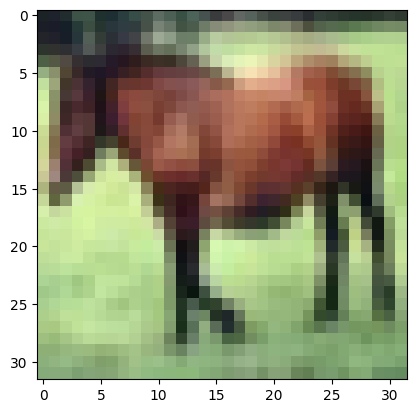

In [ ]:
# testing: plotting the image of the loaded CIFAR-10 items
img, label = full_dataset[7]
plt.imshow(img.permute(1, 2, 0))

In [ ]:
# Functions for generating synthetic text descriptions
# The synthetic texts will be of format
# A {bright/dark} {close-up/medium shot/distant} image of a {red/orange/yellow/green/blue/purple/pink/brown/gray/black/white} {classname}
# Functions for generating synthetic text descriptions
basic_colors = {
    "red": (255, 0, 0),
    "yellow": (255, 255, 0),
    "blue": (0, 0, 255),
    "purple": (128, 0, 128),
    "brown": (139, 69, 19),
    "gray": (128, 128, 128),
    "black": (0, 0, 0),
    "green": (0, 255, 0),
    "white": (255, 255, 255),
}
color_names = list(basic_colors.keys())

def rgb_to_color_name(rgb):
    best_name = None
    min_dist = float('inf')
    for name, value in basic_colors.items():
        dist = np.linalg.norm(np.array(value) - np.array(rgb))
        if dist < min_dist:
            min_dist = dist
            best_name = name
    return best_name

def get_dominant_colors_and_proportions(img, n_colors=3):
    pixels = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixels)
    cluster_centers =  kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_
    counts = np.bincount(labels)
    proportions = counts / counts.sum()
    dominant_colors = [rgb_to_color_name(rgb) for rgb in cluster_centers]
    return dominant_colors, proportions

def get_best_indices_clip_dataloader(images, all_labels, all_dominant_colors):
    texts = []
    for dominant_colors, cls_label in zip(all_dominant_colors, all_labels):
        for color in dominant_colors:
            texts.append(f"A {color} {cls_label}")

    text_tokens = tokenizer(texts).to(device)
    with torch.no_grad():
        image_features = open_clip_model.encode_image(images)
        text_features = open_clip_model.encode_text(text_tokens)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        image_features_expanded = image_features.repeat_interleave(3, dim=0)

        similarity = (image_features_expanded * text_features).sum(dim=-1)
        similarity_score = similarity.view(len(all_labels), 3)

        best_ids = similarity_score.argmax(dim=1)

    return best_ids

def get_best_index_random(dominant_colors):
    best_idx = random.randint(0, len(dominant_colors) - 1)
    return best_idx

def get_distance(best_index, proportions):
    img_proportion = proportions[best_index]
    if img_proportion > 0.4:
        return "close-up"
    elif img_proportion > 0.2:
        return "medium shot"
    else:
        return "distant"

def get_dark_or_bright(image_input_tensor):
    # Convert the image to HSV color space
    image_input = image_input_tensor.permfwute(1, 2, 0).numpy()
    hsv_img = cv2.cvtColor(image_input, cv2.COLOR_RGB2HSV)
    _, _, v_channel = cv2.split(hsv_img)
    average_brightness = v_channel.mean()
    if average_brightness < 115:
        return "dark"
    else:
        return "bright"

def get_synthetic_caption_random_color(image_input, cls_label):
    dominant_colors, proportions = get_dominant_colors_and_proportions(image_input)
    best_index = get_best_index_random(dominant_colors)
    distance = get_distance(best_index, proportions)
    brightness = get_dark_or_bright(image_input)

    caption = f"A {brightness} {distance} image of a {dominant_colors[best_index]} {cls_label}."
    return caption

def generate_and_save_synthetic_captions_random_color(dataset, start_index = 0, end_index = 10):
    with open("/cifar10_captions_random_color.csv", "a", newline='') as f:
      writer = csv.writer(f)
      for i in tqdm(range(start_index, end_index)):
          caption = get_synthetic_caption_random_color(dataset[i][0], dataset.classes[dataset[i][1]])
          writer.writerow([caption])

def generate_and_save_synthetic_captions_clip_data_loader(data_loader, data_loader_transform, classes):
    with open("/cifar10_captions_clip_color_train.csv", "a", newline='') as f:
      writer = csv.writer(f)
      for (images, labels), (images_transform, _) in tqdm(zip(data_loader, data_loader_transform)):
          dominant_colors, proportions = zip(*[get_dominant_colors_and_proportions(image_input) for image_input in images])
          labels = labels.to(device)
          images_transform = images_transform.to(device)
          all_dominant_colors = list(dominant_colors)
          all_proportions = list(proportions)
          all_brightness = [get_dark_or_bright(image_input) for image_input in images]
          best_indices = get_best_indices_clip_dataloader(images_transform, labels, all_dominant_colors)

          for i, best_index in enumerate(best_indices):
              distance = get_distance(best_index, all_proportions[i])
              caption = f"A {all_brightness[i]} {distance} image of a {all_dominant_colors[i][best_index]} {classes[labels[i]]}."
              writer.writerow([caption])


In [ ]:
# Generate synthetic captions and save the captions to json file
generate_and_save_synthetic_captions_random_color(full_dataset, 0, len(full_dataset))

In [ ]:
generate_and_save_synthetic_captions_clip_data_loader(data_loader, data_loader_transform, full_dataset.classes)

In [ ]:
class CIFAR10WithCaptions:
    def __init__(self, dataset, captions):
        self.dataset = dataset
        # self.dataset = [((img/255).float(),label) for img,label in tqdm(dataset)]
        self.class_names = dataset.classes
        self.captions = captions
        # self.captions = [c[0] for c in captions]
        # self.embedded_encodings = embedded_encodings

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        #img = (img/255).float()
        img = (img - 127.5) / 127.5
        caption = self.captions[idx]
        # encoding = self.embedded_encodings[idx]
        return img, label, caption
        # return img, label, encoding

In [ ]:
class CIFAR10WithEncodedCaptions:
    def __init__(self, dataset, encodings_path):
        self.dataset = dataset
        self.class_names = dataset.classes
        self.encodings = np.load(encodings_path).astype(np.float32)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = (img - 127.5) / 127.5
        encoding = torch.as_tensor(self.encodings[idx], dtype=torch.float32)
        return img, label, encoding

In [ ]:
# captions random colour 50000
# Read label-image pair and transform to description-image pair
captions = []
with open("cifar10_captions_random_color_50000.csv", 'r', newline='') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        captions.append(row[0])

cifar10_with_captions = CIFAR10WithCaptions(full_dataset, captions)

In [ ]:
cifar10_with_captions[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [ ]:
# RoBERTa structure
class RoBERTaModel:
    """
    Simple RoBERTa encoder
    """
    def __init__(self, model_name='roberta-base'):
        """
        Initialize RoBERTa model and tokenizer

        Available models:
        - 'roberta-base': 125M parameters, 768 hidden size
        - 'roberta-large': 355M parameters, 1024 hidden size
        - 'distilroberta-base': Smaller, faster version
        """
        print(f"Loading {model_name}...")

        # loading tokenizer and model
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.model = RobertaModel.from_pretrained(model_name).to(device)
        print(f"Model loaded successfully!")
        print(f"Config: {self.model.config}")

    def encode(self, texts, max_length=512):
        # Tokenize texts
        encoded = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            # encoding texts
            outputs = self.model(**encoded)
            # getting last hidden states
            last_hidden_states = outputs.last_hidden_state

        return last_hidden_states

# encoding with RoBERTa
roberta_model = RoBERTaModel()

Loading roberta-base...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Config: RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.55.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [ ]:
# 768 is a bit too large; we need to reduce the dimension of condition input
class Adapter(nn.Module):
    def __init__(self, input_dim=768, output_dim=156):
        """
        Adapts text embedding dimension.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x[:,0,:] # only need <S> for the embedding BX1X768
        return self.model(x)
        # uncomment for pre-encoded text
        # if x.dim() == 3:

# setting adapter size
# note that 1024 must be divisible by this size
adp = 128

adapter = Adapter(output_dim=adp).to(device)

In [ ]:
# cGAN generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(NOISE_DIM+adp, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input, encoded_text):
        encoded_text = encoded_text.unsqueeze(-1).unsqueeze(-1)
        input = torch.cat([input, encoded_text], dim=1)
        output = self.main(input)

        return output

In [ ]:
# cGAN discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (number of channels+1) x 32 x 32
            nn.Conv2d(3+1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, encoded_text):
        repeats = 1024 // adp
        encoded_text = encoded_text.repeat(1, repeats)
        encoded_text = encoded_text.view(encoded_text.shape[0], 1, 32, 32)
        input = torch.cat([input, encoded_text], dim=1)
        output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [ ]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# Training code (captions random colours)

# hyperparameters
LEARNING_RATE = 2e-4
N_EPOCHS = 50
NOISE_DIM = 100
LABEL_REAL = 1
LABEL_FAKE = 0
SAVE_INTERVAL_EPOCHS = 5

generator_k_step = 1
discriminator_k_step = 3

def GAN_training():
  # loading dataset
  train_dataset = CIFAR10WithCaptions(full_dataset, captions)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2)
  dataloader = train_dataloader
  fixed_caption = None

  # instantiating a generator netowrk
  generator = Generator().to(device)
  generator.apply(weights_init)

  # instantiating a discriminator netowrk
  discriminator = Discriminator().to(device)
  discriminator.apply(weights_init)

  # setting up the optimizers
  optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
  optimizer_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

  # setting criterion
  criterion = nn.BCELoss()

  # keeping track of loss values for plotting
  epoch_G_losses = []
  epoch_D_losses = []

  for epoch in range(N_EPOCHS):
      g_epoch_loss = 0.0
      d_epoch_loss = 0.0
      num_batches = 0
      pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{N_EPOCHS}]", leave=False)

      #for i, data in enumerate(dataloader, 0):
      for i, data in enumerate(pbar):
          # loading captions
          caption = data[2]
          encoded_text = roberta_model.encode(caption).to(device)
          encoded_text = adapter(encoded_text)

          wrong_caption = list(caption)
          random.shuffle(wrong_caption)
          wrong_encoded_text = roberta_model.encode(wrong_caption).to(device)
          wrong_encoded_text = adapter(wrong_encoded_text)

          # ===============================
          # updating discriminator network
          # ===============================
          # the goal is to maximize log(D(x)) + log(1 - D(G(z)))
          # training with real images
          for _ in range(discriminator_k_step):
            discriminator.zero_grad()
            real_samples = data[0].to(device)
            batch_size = real_samples.size(0)
            label = torch.full((batch_size,), LABEL_REAL, device=device)
            label = label.float()

            # for visualizing the progress of training
            if fixed_caption is None:
                FIXED_NOISE = torch.randn(128, NOISE_DIM, 1, 1, device=device)
                fixed_caption = caption
                fixed_real = real_samples

            output = discriminator(real_samples, encoded_text)
            error_discriminator_real = criterion(output, label)
            error_discriminator_real.backward(retain_graph=True)
            D_of_x = output.mean().item()

            # training with fake images
            noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
            fake = generator(noise, encoded_text)
            label.fill_(LABEL_FAKE)
            output = discriminator(fake.detach(), encoded_text)
            error_discriminator_fake = criterion(output, label)
            error_discriminator_fake.backward(retain_graph=True)

            # training with real images + wrong (mismatched) captions
            output = discriminator(real_samples, wrong_encoded_text)
            label.fill_(LABEL_FAKE)  # this is wrong pairing, so treat as fake
            error_mismatch = criterion(output, label)
            error_mismatch.backward(retain_graph=True)
            D_of_G_z1 = output.mean().item()

            #error_discriminator = error_discriminator_real + error_discriminator_fake
            error_discriminator = error_discriminator_real + error_discriminator_fake + error_mismatch
            optimizer_discriminator.step()

          # ===========================
          # updating generator network
          # ===========================
          # the goal is to maximize log(D(G(z)))
          for  _ in range(generator_k_step):
            generator.zero_grad()
            label.fill_(LABEL_REAL)
            output = discriminator(fake, encoded_text)
            error_generator = criterion(output, label)
            error_generator.backward()
            D_of_G_z2 = output.mean().item()
            optimizer_generator.step()

            # track losses
            g_epoch_loss += error_generator.item()
            d_epoch_loss += error_discriminator.item()
            num_batches += 1

          # print('[%d/%d][%d/%d] | Discriminator Loss: %.4f | Generator Loss: %.4f | D(x): %.4f | D(G(z)): %.4f / %.4f' % (epoch, N_EPOCHS, i, len(dataloader), error_discriminator.item(), error_generator.item(), D_of_x, D_of_G_z1, D_of_G_z2))

          # saving the output
          print('[%d/%d] | Discriminator Loss: %.4f | Generator Loss: %.4f | D(x): %.4f | D(G(z)): %.4f / %.4f' % (epoch, N_EPOCHS, error_discriminator.item(), error_generator.item(), D_of_x, D_of_G_z1, D_of_G_z2))
          epoch_G_losses.append(g_epoch_loss / num_batches)
          epoch_D_losses.append(d_epoch_loss / num_batches)
          if i % 100 == 0:
              print('saving the outputs')
              encoded_text = roberta_model.encode(fixed_caption).to(device)
              encoded_text = adapter(encoded_text).to(device)
              vutils.save_image(fixed_real,'outputs/real_samples.png',normalize=True)
              fake = generator(FIXED_NOISE, encoded_text)
              vutils.save_image(fake.detach(),'outputs/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
              # for j in range(fake.shape[0]):
              #     img = fake[j, :,:,:].detach().cpu().numpy()
              #     img = (img * 127.5 + 127.5).astype(int)
              #     #img = img * 255
              #     img = np.transpose(img, (1, 2, 0))
              #     cap = fixed_caption[j]
              #     plt.imshow(img)
              #     plt.savefig(f'current/{j}_{cap}.png', bbox_inches='tight')
              #     plt.close()

  return generator, discriminator

In [ ]:
# Evaluation code
generator, discriminator = GAN_training()

Epoch [1/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[0/50] | Discriminator Loss: 1.5419 | Generator Loss: 3.8295 | D(x): 0.5391 | D(G(z)): 0.5390 / 0.0259
saving the outputs
[0/50] | Discriminator Loss: 1.5027 | Generator Loss: 3.7191 | D(x): 0.4778 | D(G(z)): 0.4779 / 0.0286
[0/50] | Discriminator Loss: 1.5174 | Generator Loss: 4.2673 | D(x): 0.5344 | D(G(z)): 0.5342 / 0.0163
[0/50] | Discriminator Loss: 1.4440 | Generator Loss: 4.5976 | D(x): 0.5394 | D(G(z)): 0.5391 / 0.0111
[0/50] | Discriminator Loss: 1.4846 | Generator Loss: 4.6740 | D(x): 0.4923 | D(G(z)): 0.4922 / 0.0105
[0/50] | Discriminator Loss: 1.4534 | Generator Loss: 5.3823 | D(x): 0.5760 | D(G(z)): 0.5758 / 0.0052
[0/50] | Discriminator Loss: 1.5005 | Generator Loss: 4.5845 | D(x): 0.3784 | D(G(z)): 0.3784 / 0.0115
[0/50] | Discriminator Loss: 1.4668 | Generator Loss: 5.6564 | D(x): 0.6019 | D(G(z)): 0.6017 / 0.0040
[0/50] | Discriminator Loss: 1.4611 | Generator Loss: 5.0225 | D(x): 0.5634 | D(G(z)): 0.5633 / 0.0076
[0/50] | Discriminator Loss: 1.4096 | Generator Loss: 

Epoch [2/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[1/50] | Discriminator Loss: 1.4546 | Generator Loss: 4.0441 | D(x): 0.3897 | D(G(z)): 0.3877 / 0.0195
saving the outputs
[1/50] | Discriminator Loss: 1.4591 | Generator Loss: 5.0275 | D(x): 0.5928 | D(G(z)): 0.5908 / 0.0074
[1/50] | Discriminator Loss: 1.5190 | Generator Loss: 3.9341 | D(x): 0.3347 | D(G(z)): 0.3331 / 0.0216
[1/50] | Discriminator Loss: 1.4302 | Generator Loss: 4.6397 | D(x): 0.5333 | D(G(z)): 0.5319 / 0.0111
[1/50] | Discriminator Loss: 1.6450 | Generator Loss: 5.2243 | D(x): 0.7142 | D(G(z)): 0.7130 / 0.0060
[1/50] | Discriminator Loss: 1.4178 | Generator Loss: 4.6594 | D(x): 0.5143 | D(G(z)): 0.5121 / 0.0106
[1/50] | Discriminator Loss: 1.4333 | Generator Loss: 4.9951 | D(x): 0.5595 | D(G(z)): 0.5574 / 0.0078
[1/50] | Discriminator Loss: 1.4339 | Generator Loss: 4.5142 | D(x): 0.4183 | D(G(z)): 0.4162 / 0.0122
[1/50] | Discriminator Loss: 1.4088 | Generator Loss: 5.2844 | D(x): 0.5388 | D(G(z)): 0.5367 / 0.0058
[1/50] | Discriminator Loss: 1.4102 | Generator Loss: 

Epoch [3/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[2/50] | Discriminator Loss: 0.9153 | Generator Loss: 3.9229 | D(x): 0.5117 | D(G(z)): 0.1999 / 0.0223
saving the outputs
[2/50] | Discriminator Loss: 1.5322 | Generator Loss: 5.9880 | D(x): 0.8983 | D(G(z)): 0.7338 / 0.0029
[2/50] | Discriminator Loss: 0.8484 | Generator Loss: 4.8138 | D(x): 0.6670 | D(G(z)): 0.3405 / 0.0088
[2/50] | Discriminator Loss: 1.3702 | Generator Loss: 4.5505 | D(x): 0.2888 | D(G(z)): 0.1016 / 0.0122
[2/50] | Discriminator Loss: 1.0229 | Generator Loss: 4.9128 | D(x): 0.5535 | D(G(z)): 0.3365 / 0.0085
[2/50] | Discriminator Loss: 0.8769 | Generator Loss: 3.8414 | D(x): 0.5641 | D(G(z)): 0.2382 / 0.0256
[2/50] | Discriminator Loss: 1.1252 | Generator Loss: 5.2421 | D(x): 0.8598 | D(G(z)): 0.5744 / 0.0060
[2/50] | Discriminator Loss: 0.7589 | Generator Loss: 4.2917 | D(x): 0.6766 | D(G(z)): 0.2790 / 0.0156
[2/50] | Discriminator Loss: 0.6938 | Generator Loss: 4.5808 | D(x): 0.6742 | D(G(z)): 0.2327 / 0.0124
[2/50] | Discriminator Loss: 0.7089 | Generator Loss: 

Epoch [4/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[3/50] | Discriminator Loss: 0.0674 | Generator Loss: 5.7625 | D(x): 0.9629 | D(G(z)): 0.0235 / 0.0042
saving the outputs
[3/50] | Discriminator Loss: 0.0519 | Generator Loss: 5.4047 | D(x): 0.9749 | D(G(z)): 0.0184 / 0.0053
[3/50] | Discriminator Loss: 0.0317 | Generator Loss: 6.9453 | D(x): 0.9800 | D(G(z)): 0.0098 / 0.0012
[3/50] | Discriminator Loss: 0.0459 | Generator Loss: 6.3442 | D(x): 0.9745 | D(G(z)): 0.0172 / 0.0020
[3/50] | Discriminator Loss: 0.0447 | Generator Loss: 5.0295 | D(x): 0.9846 | D(G(z)): 0.0130 / 0.0077
[3/50] | Discriminator Loss: 0.0320 | Generator Loss: 6.0620 | D(x): 0.9823 | D(G(z)): 0.0106 / 0.0027
[3/50] | Discriminator Loss: 0.0426 | Generator Loss: 4.6636 | D(x): 0.9822 | D(G(z)): 0.0040 / 0.0110
[3/50] | Discriminator Loss: 0.0367 | Generator Loss: 6.5731 | D(x): 0.9703 | D(G(z)): 0.0047 / 0.0017
[3/50] | Discriminator Loss: 0.0288 | Generator Loss: 6.5934 | D(x): 0.9817 | D(G(z)): 0.0076 / 0.0017
[3/50] | Discriminator Loss: 0.0377 | Generator Loss: 

Epoch [5/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[4/50] | Discriminator Loss: 0.3686 | Generator Loss: 14.7357 | D(x): 0.9990 | D(G(z)): 0.0671 / 0.0000
saving the outputs
[4/50] | Discriminator Loss: 1.0889 | Generator Loss: 4.7975 | D(x): 0.4197 | D(G(z)): 0.0106 / 0.0512
[4/50] | Discriminator Loss: 2.9746 | Generator Loss: 9.0695 | D(x): 0.4605 | D(G(z)): 0.1628 / 0.0014
[4/50] | Discriminator Loss: 0.3741 | Generator Loss: 6.4232 | D(x): 0.7649 | D(G(z)): 0.0709 / 0.0058
[4/50] | Discriminator Loss: 0.1336 | Generator Loss: 5.8973 | D(x): 0.9623 | D(G(z)): 0.0835 / 0.0037
[4/50] | Discriminator Loss: 0.0747 | Generator Loss: 5.8049 | D(x): 0.9595 | D(G(z)): 0.0257 / 0.0046
[4/50] | Discriminator Loss: 0.0529 | Generator Loss: 5.9209 | D(x): 0.9819 | D(G(z)): 0.0272 / 0.0035
[4/50] | Discriminator Loss: 0.0423 | Generator Loss: 5.2710 | D(x): 0.9789 | D(G(z)): 0.0090 / 0.0065
[4/50] | Discriminator Loss: 0.0230 | Generator Loss: 5.9478 | D(x): 0.9881 | D(G(z)): 0.0069 / 0.0031
[4/50] | Discriminator Loss: 0.0908 | Generator Loss:

Epoch [6/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[5/50] | Discriminator Loss: 0.0212 | Generator Loss: 5.1583 | D(x): 0.9989 | D(G(z)): 0.0003 / 0.0072
saving the outputs
[5/50] | Discriminator Loss: 0.0124 | Generator Loss: 9.3026 | D(x): 0.9882 | D(G(z)): 0.0002 / 0.0001
[5/50] | Discriminator Loss: 0.0053 | Generator Loss: 7.3862 | D(x): 0.9961 | D(G(z)): 0.0006 / 0.0008
[5/50] | Discriminator Loss: 0.0131 | Generator Loss: 5.6114 | D(x): 0.9912 | D(G(z)): 0.0001 / 0.0045
[5/50] | Discriminator Loss: 0.0634 | Generator Loss: 4.9300 | D(x): 0.9811 | D(G(z)): 0.0016 / 0.0089
[5/50] | Discriminator Loss: 0.0165 | Generator Loss: 8.8277 | D(x): 0.9840 | D(G(z)): 0.0000 / 0.0002
[5/50] | Discriminator Loss: 0.0129 | Generator Loss: 6.7842 | D(x): 0.9897 | D(G(z)): 0.0006 / 0.0015
[5/50] | Discriminator Loss: 0.0198 | Generator Loss: 5.2695 | D(x): 0.9946 | D(G(z)): 0.0004 / 0.0067
[5/50] | Discriminator Loss: 0.0136 | Generator Loss: 7.4402 | D(x): 0.9880 | D(G(z)): 0.0003 / 0.0008
[5/50] | Discriminator Loss: 0.0047 | Generator Loss: 

Epoch [7/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[6/50] | Discriminator Loss: 0.1568 | Generator Loss: 8.8852 | D(x): 0.8987 | D(G(z)): 0.0401 / 0.0007
saving the outputs
[6/50] | Discriminator Loss: 0.0990 | Generator Loss: 5.7537 | D(x): 0.9767 | D(G(z)): 0.0431 / 0.0078
[6/50] | Discriminator Loss: 0.0473 | Generator Loss: 8.2205 | D(x): 0.9560 | D(G(z)): 0.0008 / 0.0007
[6/50] | Discriminator Loss: 0.0305 | Generator Loss: 5.5206 | D(x): 0.9893 | D(G(z)): 0.0089 / 0.0086
[6/50] | Discriminator Loss: 0.0853 | Generator Loss: 7.1355 | D(x): 0.9291 | D(G(z)): 0.0049 / 0.0019
[6/50] | Discriminator Loss: 0.0658 | Generator Loss: 7.6356 | D(x): 0.9420 | D(G(z)): 0.0029 / 0.0009
[6/50] | Discriminator Loss: 0.0282 | Generator Loss: 5.1910 | D(x): 0.9898 | D(G(z)): 0.0062 / 0.0092
[6/50] | Discriminator Loss: 0.1437 | Generator Loss: 6.4064 | D(x): 0.8775 | D(G(z)): 0.0026 / 0.0025
[6/50] | Discriminator Loss: 0.0615 | Generator Loss: 5.7792 | D(x): 0.9774 | D(G(z)): 0.0233 / 0.0052
[6/50] | Discriminator Loss: 0.0567 | Generator Loss: 

Epoch [8/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[7/50] | Discriminator Loss: 0.0702 | Generator Loss: 5.2091 | D(x): 0.9958 | D(G(z)): 0.0052 / 0.0080
saving the outputs
[7/50] | Discriminator Loss: 0.0303 | Generator Loss: 3.7100 | D(x): 0.9872 | D(G(z)): 0.0048 / 0.0351
[7/50] | Discriminator Loss: 0.0833 | Generator Loss: 7.0031 | D(x): 0.9263 | D(G(z)): 0.0017 / 0.0015
[7/50] | Discriminator Loss: 0.0137 | Generator Loss: 5.4409 | D(x): 0.9947 | D(G(z)): 0.0005 / 0.0069
[7/50] | Discriminator Loss: 0.0183 | Generator Loss: 6.9571 | D(x): 0.9848 | D(G(z)): 0.0008 / 0.0013
[7/50] | Discriminator Loss: 0.0706 | Generator Loss: 4.0046 | D(x): 0.9657 | D(G(z)): 0.0002 / 0.0276
[7/50] | Discriminator Loss: 0.3348 | Generator Loss: 2.8358 | D(x): 0.9996 | D(G(z)): 0.1844 / 0.0980
[7/50] | Discriminator Loss: 0.1245 | Generator Loss: 6.5458 | D(x): 0.8943 | D(G(z)): 0.0051 / 0.0035
[7/50] | Discriminator Loss: 0.0397 | Generator Loss: 8.4322 | D(x): 0.9719 | D(G(z)): 0.0088 / 0.0004
[7/50] | Discriminator Loss: 0.0614 | Generator Loss: 

Epoch [9/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[8/50] | Discriminator Loss: 0.0689 | Generator Loss: 4.3672 | D(x): 0.9700 | D(G(z)): 0.0005 / 0.0176
saving the outputs
[8/50] | Discriminator Loss: 0.0629 | Generator Loss: 3.7728 | D(x): 0.9991 | D(G(z)): 0.0503 / 0.0415
[8/50] | Discriminator Loss: 0.0687 | Generator Loss: 4.9859 | D(x): 0.9544 | D(G(z)): 0.0094 / 0.0131
[8/50] | Discriminator Loss: 0.0665 | Generator Loss: 6.6485 | D(x): 0.9984 | D(G(z)): 0.0581 / 0.0026
[8/50] | Discriminator Loss: 0.1257 | Generator Loss: 8.1613 | D(x): 0.8951 | D(G(z)): 0.0104 / 0.0005
[8/50] | Discriminator Loss: 0.0629 | Generator Loss: 6.5214 | D(x): 0.9519 | D(G(z)): 0.0087 / 0.0023
[8/50] | Discriminator Loss: 0.0573 | Generator Loss: 5.7345 | D(x): 0.9635 | D(G(z)): 0.0132 / 0.0049
[8/50] | Discriminator Loss: 0.0848 | Generator Loss: 4.8865 | D(x): 0.9310 | D(G(z)): 0.0043 / 0.0107
[8/50] | Discriminator Loss: 0.0751 | Generator Loss: 4.2590 | D(x): 0.9907 | D(G(z)): 0.0049 / 0.0192
[8/50] | Discriminator Loss: 0.0317 | Generator Loss: 

Epoch [10/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[9/50] | Discriminator Loss: 0.1047 | Generator Loss: 5.0106 | D(x): 0.9884 | D(G(z)): 0.0035 / 0.0098
saving the outputs
[9/50] | Discriminator Loss: 0.2758 | Generator Loss: 7.5286 | D(x): 0.9922 | D(G(z)): 0.0066 / 0.0007
[9/50] | Discriminator Loss: 0.0246 | Generator Loss: 6.8621 | D(x): 0.9773 | D(G(z)): 0.0004 / 0.0018
[9/50] | Discriminator Loss: 0.0158 | Generator Loss: 6.4213 | D(x): 0.9921 | D(G(z)): 0.0045 / 0.0035
[9/50] | Discriminator Loss: 0.1771 | Generator Loss: 5.6741 | D(x): 0.9842 | D(G(z)): 0.0042 / 0.0049
[9/50] | Discriminator Loss: 0.1064 | Generator Loss: 5.5223 | D(x): 0.9964 | D(G(z)): 0.0113 / 0.0060
[9/50] | Discriminator Loss: 0.0433 | Generator Loss: 5.2030 | D(x): 0.9644 | D(G(z)): 0.0011 / 0.0089
[9/50] | Discriminator Loss: 0.0660 | Generator Loss: 4.6047 | D(x): 0.9816 | D(G(z)): 0.0034 / 0.0143
[9/50] | Discriminator Loss: 0.0360 | Generator Loss: 6.1119 | D(x): 0.9722 | D(G(z)): 0.0009 / 0.0039
[9/50] | Discriminator Loss: 1.5175 | Generator Loss: 

Epoch [11/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[10/50] | Discriminator Loss: 0.0556 | Generator Loss: 5.7628 | D(x): 0.9614 | D(G(z)): 0.0018 / 0.0067
saving the outputs
[10/50] | Discriminator Loss: 0.0972 | Generator Loss: 6.9366 | D(x): 0.9146 | D(G(z)): 0.0014 / 0.0021
[10/50] | Discriminator Loss: 0.0971 | Generator Loss: 4.9854 | D(x): 0.9921 | D(G(z)): 0.0150 / 0.0117
[10/50] | Discriminator Loss: 0.1225 | Generator Loss: 6.5815 | D(x): 0.8917 | D(G(z)): 0.0007 / 0.0029
[10/50] | Discriminator Loss: 0.0478 | Generator Loss: 4.6419 | D(x): 0.9668 | D(G(z)): 0.0005 / 0.0163
[10/50] | Discriminator Loss: 0.0481 | Generator Loss: 3.7393 | D(x): 0.9797 | D(G(z)): 0.0020 / 0.0421
[10/50] | Discriminator Loss: 0.1650 | Generator Loss: 4.2535 | D(x): 0.9683 | D(G(z)): 0.0042 / 0.0259
[10/50] | Discriminator Loss: 0.1580 | Generator Loss: 5.1871 | D(x): 0.8702 | D(G(z)): 0.0047 / 0.0097
[10/50] | Discriminator Loss: 0.0743 | Generator Loss: 4.1725 | D(x): 0.9690 | D(G(z)): 0.0025 / 0.0246
[10/50] | Discriminator Loss: 0.0710 | Genera

Epoch [12/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[11/50] | Discriminator Loss: 0.0385 | Generator Loss: 8.4237 | D(x): 0.9688 | D(G(z)): 0.0058 / 0.0010
saving the outputs
[11/50] | Discriminator Loss: 0.0672 | Generator Loss: 5.5092 | D(x): 0.9562 | D(G(z)): 0.0081 / 0.0073
[11/50] | Discriminator Loss: 0.0346 | Generator Loss: 7.1772 | D(x): 0.9700 | D(G(z)): 0.0017 / 0.0012
[11/50] | Discriminator Loss: 0.1396 | Generator Loss: 4.8395 | D(x): 0.9920 | D(G(z)): 0.0038 / 0.0114
[11/50] | Discriminator Loss: 0.0578 | Generator Loss: 4.6596 | D(x): 0.9641 | D(G(z)): 0.0054 / 0.0144
[11/50] | Discriminator Loss: 0.0804 | Generator Loss: 4.4923 | D(x): 0.9529 | D(G(z)): 0.0073 / 0.0177
[11/50] | Discriminator Loss: 0.0436 | Generator Loss: 4.7896 | D(x): 0.9724 | D(G(z)): 0.0011 / 0.0135
[11/50] | Discriminator Loss: 0.0167 | Generator Loss: 4.4561 | D(x): 0.9922 | D(G(z)): 0.0007 / 0.0289
[11/50] | Discriminator Loss: 0.0372 | Generator Loss: 5.9760 | D(x): 0.9759 | D(G(z)): 0.0036 / 0.0049
[11/50] | Discriminator Loss: 0.0632 | Genera

Epoch [13/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[12/50] | Discriminator Loss: 0.0237 | Generator Loss: 6.0357 | D(x): 0.9848 | D(G(z)): 0.0039 / 0.0039
saving the outputs
[12/50] | Discriminator Loss: 0.0619 | Generator Loss: 6.7819 | D(x): 0.9447 | D(G(z)): 0.0005 / 0.0021
[12/50] | Discriminator Loss: 0.0195 | Generator Loss: 5.7281 | D(x): 0.9938 | D(G(z)): 0.0064 / 0.0053
[12/50] | Discriminator Loss: 0.0749 | Generator Loss: 4.3695 | D(x): 0.9966 | D(G(z)): 0.0054 / 0.0201
[12/50] | Discriminator Loss: 0.0217 | Generator Loss: 6.2335 | D(x): 0.9885 | D(G(z)): 0.0051 / 0.0032
[12/50] | Discriminator Loss: 0.0456 | Generator Loss: 6.8492 | D(x): 0.9595 | D(G(z)): 0.0020 / 0.0022
[12/50] | Discriminator Loss: 0.0142 | Generator Loss: 5.3325 | D(x): 0.9963 | D(G(z)): 0.0022 / 0.0083
[12/50] | Discriminator Loss: 0.0147 | Generator Loss: 6.7247 | D(x): 0.9897 | D(G(z)): 0.0010 / 0.0022
[12/50] | Discriminator Loss: 0.0199 | Generator Loss: 5.4734 | D(x): 0.9904 | D(G(z)): 0.0023 / 0.0069
[12/50] | Discriminator Loss: 0.0378 | Genera

Epoch [14/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[13/50] | Discriminator Loss: 0.0335 | Generator Loss: 5.0286 | D(x): 0.9944 | D(G(z)): 0.0006 / 0.0096
saving the outputs
[13/50] | Discriminator Loss: 0.0362 | Generator Loss: 6.5175 | D(x): 0.9734 | D(G(z)): 0.0020 / 0.0022
[13/50] | Discriminator Loss: 0.0174 | Generator Loss: 5.5190 | D(x): 0.9897 | D(G(z)): 0.0012 / 0.0062
[13/50] | Discriminator Loss: 0.0246 | Generator Loss: 6.3725 | D(x): 0.9821 | D(G(z)): 0.0037 / 0.0026
[13/50] | Discriminator Loss: 0.0388 | Generator Loss: 5.0742 | D(x): 0.9742 | D(G(z)): 0.0012 / 0.0098
[13/50] | Discriminator Loss: 0.0256 | Generator Loss: 4.7750 | D(x): 0.9955 | D(G(z)): 0.0018 / 0.0127
[13/50] | Discriminator Loss: 3.1311 | Generator Loss: 12.1430 | D(x): 1.0000 | D(G(z)): 0.9061 / 0.0000
[13/50] | Discriminator Loss: 0.7487 | Generator Loss: 6.7608 | D(x): 0.5754 | D(G(z)): 0.0015 / 0.0031
[13/50] | Discriminator Loss: 0.1642 | Generator Loss: 4.6916 | D(x): 0.9485 | D(G(z)): 0.0204 / 0.0157
[13/50] | Discriminator Loss: 0.1065 | Gener

Epoch [15/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[14/50] | Discriminator Loss: 0.0155 | Generator Loss: 7.7789 | D(x): 0.9866 | D(G(z)): 0.0012 / 0.0007
saving the outputs
[14/50] | Discriminator Loss: 0.0325 | Generator Loss: 5.4695 | D(x): 0.9834 | D(G(z)): 0.0009 / 0.0062
[14/50] | Discriminator Loss: 0.0313 | Generator Loss: 4.8882 | D(x): 0.9966 | D(G(z)): 0.0023 / 0.0115
[14/50] | Discriminator Loss: 0.0379 | Generator Loss: 5.5906 | D(x): 0.9733 | D(G(z)): 0.0032 / 0.0057
[14/50] | Discriminator Loss: 0.0260 | Generator Loss: 6.2649 | D(x): 0.9800 | D(G(z)): 0.0004 / 0.0031
[14/50] | Discriminator Loss: 0.0242 | Generator Loss: 6.4001 | D(x): 0.9858 | D(G(z)): 0.0034 / 0.0028
[14/50] | Discriminator Loss: 0.0151 | Generator Loss: 5.6524 | D(x): 0.9912 | D(G(z)): 0.0009 / 0.0051
[14/50] | Discriminator Loss: 0.0336 | Generator Loss: 5.1817 | D(x): 0.9895 | D(G(z)): 0.0016 / 0.0081
[14/50] | Discriminator Loss: 0.0239 | Generator Loss: 6.3488 | D(x): 0.9801 | D(G(z)): 0.0005 / 0.0027
[14/50] | Discriminator Loss: 0.0302 | Genera

Epoch [16/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[15/50] | Discriminator Loss: 0.0302 | Generator Loss: 4.9342 | D(x): 0.9932 | D(G(z)): 0.0001 / 0.0121
saving the outputs
[15/50] | Discriminator Loss: 0.0255 | Generator Loss: 6.5162 | D(x): 0.9779 | D(G(z)): 0.0011 / 0.0026
[15/50] | Discriminator Loss: 0.0497 | Generator Loss: 4.7554 | D(x): 0.9869 | D(G(z)): 0.0012 / 0.0126
[15/50] | Discriminator Loss: 0.0361 | Generator Loss: 4.2063 | D(x): 0.9965 | D(G(z)): 0.0100 / 0.0392
[15/50] | Discriminator Loss: 0.0320 | Generator Loss: 7.4530 | D(x): 0.9728 | D(G(z)): 0.0024 / 0.0013
[15/50] | Discriminator Loss: 0.0378 | Generator Loss: 5.7917 | D(x): 0.9866 | D(G(z)): 0.0077 / 0.0057
[15/50] | Discriminator Loss: 0.0172 | Generator Loss: 5.6941 | D(x): 0.9894 | D(G(z)): 0.0002 / 0.0056
[15/50] | Discriminator Loss: 0.0168 | Generator Loss: 6.4318 | D(x): 0.9894 | D(G(z)): 0.0033 / 0.0028
[15/50] | Discriminator Loss: 0.0183 | Generator Loss: 6.2105 | D(x): 0.9887 | D(G(z)): 0.0023 / 0.0035
[15/50] | Discriminator Loss: 0.0347 | Genera

Epoch [17/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[16/50] | Discriminator Loss: 0.0449 | Generator Loss: 4.6668 | D(x): 0.9991 | D(G(z)): 0.0156 / 0.0574
saving the outputs
[16/50] | Discriminator Loss: 0.0896 | Generator Loss: 6.6016 | D(x): 0.9517 | D(G(z)): 0.0057 / 0.0029
[16/50] | Discriminator Loss: 0.0303 | Generator Loss: 6.6135 | D(x): 0.9804 | D(G(z)): 0.0060 / 0.0029
[16/50] | Discriminator Loss: 0.0358 | Generator Loss: 5.3058 | D(x): 0.9970 | D(G(z)): 0.0014 / 0.0090
[16/50] | Discriminator Loss: 0.0175 | Generator Loss: 5.7421 | D(x): 0.9984 | D(G(z)): 0.0021 / 0.0056
[16/50] | Discriminator Loss: 0.0150 | Generator Loss: 6.1784 | D(x): 0.9900 | D(G(z)): 0.0014 / 0.0042
[16/50] | Discriminator Loss: 0.0285 | Generator Loss: 5.5824 | D(x): 0.9799 | D(G(z)): 0.0005 / 0.0061
[16/50] | Discriminator Loss: 3.1495 | Generator Loss: 12.9622 | D(x): 1.0000 | D(G(z)): 0.9016 / 0.0000
[16/50] | Discriminator Loss: 0.2699 | Generator Loss: 6.7709 | D(x): 0.9998 | D(G(z)): 0.1290 / 0.0021
[16/50] | Discriminator Loss: 0.2860 | Gener

Epoch [18/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[17/50] | Discriminator Loss: 0.0103 | Generator Loss: 6.0942 | D(x): 0.9945 | D(G(z)): 0.0004 / 0.0039
saving the outputs
[17/50] | Discriminator Loss: 0.0206 | Generator Loss: 5.5327 | D(x): 0.9882 | D(G(z)): 0.0004 / 0.0063
[17/50] | Discriminator Loss: 0.2356 | Generator Loss: 9.4450 | D(x): 0.8051 | D(G(z)): 0.0000 / 0.0002
[17/50] | Discriminator Loss: 0.0057 | Generator Loss: 10.0240 | D(x): 0.9977 | D(G(z)): 0.0024 / 0.0002
[17/50] | Discriminator Loss: 0.0223 | Generator Loss: 6.6085 | D(x): 0.9902 | D(G(z)): 0.0100 / 0.0026
[17/50] | Discriminator Loss: 0.0141 | Generator Loss: 6.8505 | D(x): 0.9946 | D(G(z)): 0.0063 / 0.0023
[17/50] | Discriminator Loss: 0.0184 | Generator Loss: 6.5299 | D(x): 0.9883 | D(G(z)): 0.0012 / 0.0024
[17/50] | Discriminator Loss: 0.0096 | Generator Loss: 6.6114 | D(x): 0.9926 | D(G(z)): 0.0003 / 0.0022
[17/50] | Discriminator Loss: 0.0243 | Generator Loss: 4.9598 | D(x): 0.9934 | D(G(z)): 0.0014 / 0.0105
[17/50] | Discriminator Loss: 0.0219 | Gener

Epoch [19/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[18/50] | Discriminator Loss: 0.0410 | Generator Loss: 8.1257 | D(x): 0.9664 | D(G(z)): 0.0059 / 0.0005
saving the outputs
[18/50] | Discriminator Loss: 0.0538 | Generator Loss: 5.0192 | D(x): 0.9911 | D(G(z)): 0.0012 / 0.0108
[18/50] | Discriminator Loss: 0.0368 | Generator Loss: 4.7657 | D(x): 0.9867 | D(G(z)): 0.0019 / 0.0126
[18/50] | Discriminator Loss: 0.0575 | Generator Loss: 5.0646 | D(x): 0.9893 | D(G(z)): 0.0014 / 0.0091
[18/50] | Discriminator Loss: 0.0355 | Generator Loss: 5.3900 | D(x): 0.9825 | D(G(z)): 0.0073 / 0.0070
[18/50] | Discriminator Loss: 0.0167 | Generator Loss: 4.7488 | D(x): 0.9966 | D(G(z)): 0.0040 / 0.0246
[18/50] | Discriminator Loss: 0.0175 | Generator Loss: 6.4052 | D(x): 0.9934 | D(G(z)): 0.0012 / 0.0027
[18/50] | Discriminator Loss: 0.0192 | Generator Loss: 6.3838 | D(x): 0.9834 | D(G(z)): 0.0002 / 0.0025
[18/50] | Discriminator Loss: 0.0130 | Generator Loss: 5.6053 | D(x): 0.9933 | D(G(z)): 0.0025 / 0.0067
[18/50] | Discriminator Loss: 0.0139 | Genera

Epoch [20/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[19/50] | Discriminator Loss: 0.0409 | Generator Loss: 6.3603 | D(x): 0.9652 | D(G(z)): 0.0011 / 0.0028
saving the outputs
[19/50] | Discriminator Loss: 0.0302 | Generator Loss: 4.6524 | D(x): 0.9915 | D(G(z)): 0.0008 / 0.0152
[19/50] | Discriminator Loss: 0.0496 | Generator Loss: 5.9058 | D(x): 0.9590 | D(G(z)): 0.0003 / 0.0050
[19/50] | Discriminator Loss: 0.0230 | Generator Loss: 6.1301 | D(x): 0.9927 | D(G(z)): 0.0012 / 0.0039
[19/50] | Discriminator Loss: 0.0269 | Generator Loss: 5.3179 | D(x): 0.9846 | D(G(z)): 0.0001 / 0.0075
[19/50] | Discriminator Loss: 0.0245 | Generator Loss: 5.3488 | D(x): 0.9908 | D(G(z)): 0.0001 / 0.0086
[19/50] | Discriminator Loss: 0.0247 | Generator Loss: 6.5619 | D(x): 0.9785 | D(G(z)): 0.0010 / 0.0023
[19/50] | Discriminator Loss: 0.0331 | Generator Loss: 5.1941 | D(x): 0.9922 | D(G(z)): 0.0007 / 0.0087
[19/50] | Discriminator Loss: 0.0246 | Generator Loss: 5.4130 | D(x): 0.9831 | D(G(z)): 0.0004 / 0.0073
[19/50] | Discriminator Loss: 0.0434 | Genera

Epoch [21/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[20/50] | Discriminator Loss: 0.0054 | Generator Loss: 9.5265 | D(x): 0.9967 | D(G(z)): 0.0017 / 0.0002
saving the outputs
[20/50] | Discriminator Loss: 0.0157 | Generator Loss: 7.0833 | D(x): 0.9899 | D(G(z)): 0.0038 / 0.0018
[20/50] | Discriminator Loss: 5.8656 | Generator Loss: 22.5750 | D(x): 1.0000 | D(G(z)): 0.5418 / 0.0000
[20/50] | Discriminator Loss: 5.8553 | Generator Loss: 17.3148 | D(x): 0.9967 | D(G(z)): 0.9124 / 0.0000
[20/50] | Discriminator Loss: 8.3528 | Generator Loss: 10.2469 | D(x): 0.9946 | D(G(z)): 0.9534 / 0.0003
[20/50] | Discriminator Loss: 3.3785 | Generator Loss: 6.0379 | D(x): 0.9704 | D(G(z)): 0.8641 / 0.0058
[20/50] | Discriminator Loss: 0.7539 | Generator Loss: 3.8512 | D(x): 0.9449 | D(G(z)): 0.2492 / 0.0508
[20/50] | Discriminator Loss: 1.1439 | Generator Loss: 3.9062 | D(x): 0.7010 | D(G(z)): 0.1597 / 0.0477
[20/50] | Discriminator Loss: 0.5602 | Generator Loss: 3.2142 | D(x): 0.6950 | D(G(z)): 0.0272 / 0.0566
[20/50] | Discriminator Loss: 0.5337 | Gen

Epoch [22/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[21/50] | Discriminator Loss: 0.0475 | Generator Loss: 8.4830 | D(x): 0.9556 | D(G(z)): 0.0001 / 0.0004
saving the outputs
[21/50] | Discriminator Loss: 0.0289 | Generator Loss: 4.6821 | D(x): 0.9930 | D(G(z)): 0.0003 / 0.0132
[21/50] | Discriminator Loss: 0.0217 | Generator Loss: 6.5167 | D(x): 0.9830 | D(G(z)): 0.0012 / 0.0023
[21/50] | Discriminator Loss: 0.0279 | Generator Loss: 4.8181 | D(x): 0.9835 | D(G(z)): 0.0001 / 0.0165
[21/50] | Discriminator Loss: 0.0567 | Generator Loss: 5.6014 | D(x): 0.9515 | D(G(z)): 0.0001 / 0.0064
[21/50] | Discriminator Loss: 0.0286 | Generator Loss: 4.9464 | D(x): 0.9867 | D(G(z)): 0.0002 / 0.0104
[21/50] | Discriminator Loss: 0.0497 | Generator Loss: 5.3262 | D(x): 0.9618 | D(G(z)): 0.0003 / 0.0081
[21/50] | Discriminator Loss: 0.0388 | Generator Loss: 5.7015 | D(x): 0.9689 | D(G(z)): 0.0002 / 0.0047
[21/50] | Discriminator Loss: 0.0250 | Generator Loss: 5.4929 | D(x): 0.9861 | D(G(z)): 0.0001 / 0.0067
[21/50] | Discriminator Loss: 0.0516 | Genera

Epoch [23/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[22/50] | Discriminator Loss: 0.0102 | Generator Loss: 7.2474 | D(x): 0.9908 | D(G(z)): 0.0001 / 0.0012
saving the outputs
[22/50] | Discriminator Loss: 0.0209 | Generator Loss: 5.7845 | D(x): 0.9922 | D(G(z)): 0.0004 / 0.0048
[22/50] | Discriminator Loss: 0.0074 | Generator Loss: 7.1278 | D(x): 0.9940 | D(G(z)): 0.0002 / 0.0013
[22/50] | Discriminator Loss: 0.0161 | Generator Loss: 5.3880 | D(x): 0.9965 | D(G(z)): 0.0003 / 0.0069
[22/50] | Discriminator Loss: 0.0077 | Generator Loss: 6.5371 | D(x): 0.9955 | D(G(z)): 0.0002 / 0.0023
[22/50] | Discriminator Loss: 0.0138 | Generator Loss: 6.4362 | D(x): 0.9904 | D(G(z)): 0.0006 / 0.0025
[22/50] | Discriminator Loss: 0.0540 | Generator Loss: 6.6159 | D(x): 0.9966 | D(G(z)): 0.0001 / 0.0020
[22/50] | Discriminator Loss: 0.0102 | Generator Loss: 8.3577 | D(x): 0.9903 | D(G(z)): 0.0000 / 0.0004
[22/50] | Discriminator Loss: 0.0104 | Generator Loss: 5.4924 | D(x): 0.9973 | D(G(z)): 0.0003 / 0.0065
[22/50] | Discriminator Loss: 0.0183 | Genera

Epoch [24/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[23/50] | Discriminator Loss: 0.0252 | Generator Loss: 5.2729 | D(x): 0.9928 | D(G(z)): 0.0023 / 0.0108
saving the outputs
[23/50] | Discriminator Loss: 0.0241 | Generator Loss: 5.9232 | D(x): 0.9831 | D(G(z)): 0.0002 / 0.0050
[23/50] | Discriminator Loss: 0.0886 | Generator Loss: 5.0731 | D(x): 0.9942 | D(G(z)): 0.0014 / 0.0094
[23/50] | Discriminator Loss: 0.1019 | Generator Loss: 3.6489 | D(x): 0.9991 | D(G(z)): 0.0010 / 0.0407
[23/50] | Discriminator Loss: 0.2445 | Generator Loss: 11.7269 | D(x): 0.8228 | D(G(z)): 0.0000 / 0.0000
[23/50] | Discriminator Loss: 0.0364 | Generator Loss: 6.7342 | D(x): 0.9998 | D(G(z)): 0.0206 / 0.0040
[23/50] | Discriminator Loss: 0.0783 | Generator Loss: 8.3518 | D(x): 0.9340 | D(G(z)): 0.0005 / 0.0004
[23/50] | Discriminator Loss: 0.0195 | Generator Loss: 7.1666 | D(x): 0.9827 | D(G(z)): 0.0002 / 0.0014
[23/50] | Discriminator Loss: 0.0212 | Generator Loss: 5.1151 | D(x): 0.9901 | D(G(z)): 0.0008 / 0.0094
[23/50] | Discriminator Loss: 0.0641 | Gener

Epoch [25/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[24/50] | Discriminator Loss: 0.0035 | Generator Loss: 6.8002 | D(x): 0.9992 | D(G(z)): 0.0014 / 0.0019
saving the outputs
[24/50] | Discriminator Loss: 0.0069 | Generator Loss: 7.8029 | D(x): 0.9957 | D(G(z)): 0.0003 / 0.0007
[24/50] | Discriminator Loss: 0.0123 | Generator Loss: 6.6689 | D(x): 0.9897 | D(G(z)): 0.0001 / 0.0022
[24/50] | Discriminator Loss: 0.0062 | Generator Loss: 7.0296 | D(x): 0.9970 | D(G(z)): 0.0014 / 0.0014
[24/50] | Discriminator Loss: 0.0127 | Generator Loss: 5.9529 | D(x): 0.9912 | D(G(z)): 0.0001 / 0.0039
[24/50] | Discriminator Loss: 0.0078 | Generator Loss: 7.4619 | D(x): 0.9932 | D(G(z)): 0.0005 / 0.0009
[24/50] | Discriminator Loss: 0.0089 | Generator Loss: 6.1576 | D(x): 0.9963 | D(G(z)): 0.0005 / 0.0037
[24/50] | Discriminator Loss: 0.0108 | Generator Loss: 7.2427 | D(x): 0.9909 | D(G(z)): 0.0003 / 0.0011
[24/50] | Discriminator Loss: 0.0181 | Generator Loss: 5.3633 | D(x): 0.9911 | D(G(z)): 0.0003 / 0.0062
[24/50] | Discriminator Loss: 0.0106 | Genera

Epoch [26/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[25/50] | Discriminator Loss: 0.0131 | Generator Loss: 5.9882 | D(x): 0.9924 | D(G(z)): 0.0007 / 0.0043
saving the outputs
[25/50] | Discriminator Loss: 0.0069 | Generator Loss: 7.2383 | D(x): 0.9965 | D(G(z)): 0.0017 / 0.0013
[25/50] | Discriminator Loss: 0.0274 | Generator Loss: 5.1633 | D(x): 0.9885 | D(G(z)): 0.0001 / 0.0096
[25/50] | Discriminator Loss: 0.0708 | Generator Loss: 5.2887 | D(x): 0.9979 | D(G(z)): 0.0011 / 0.0077
[25/50] | Discriminator Loss: 0.0274 | Generator Loss: 5.9312 | D(x): 0.9783 | D(G(z)): 0.0000 / 0.0050
[25/50] | Discriminator Loss: 0.0130 | Generator Loss: 6.3379 | D(x): 0.9920 | D(G(z)): 0.0002 / 0.0034
[25/50] | Discriminator Loss: 0.0586 | Generator Loss: 4.4890 | D(x): 0.9931 | D(G(z)): 0.0005 / 0.0159
[25/50] | Discriminator Loss: 0.0456 | Generator Loss: 6.3612 | D(x): 0.9596 | D(G(z)): 0.0003 / 0.0027
[25/50] | Discriminator Loss: 0.0175 | Generator Loss: 5.2458 | D(x): 0.9920 | D(G(z)): 0.0001 / 0.0087
[25/50] | Discriminator Loss: 0.0127 | Genera

Epoch [27/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[26/50] | Discriminator Loss: 0.0251 | Generator Loss: 5.5543 | D(x): 0.9843 | D(G(z)): 0.0003 / 0.0073
saving the outputs
[26/50] | Discriminator Loss: 0.0290 | Generator Loss: 7.0097 | D(x): 0.9792 | D(G(z)): 0.0001 / 0.0033
[26/50] | Discriminator Loss: 0.0112 | Generator Loss: 7.5013 | D(x): 0.9942 | D(G(z)): 0.0001 / 0.0022
[26/50] | Discriminator Loss: 0.0306 | Generator Loss: 5.1014 | D(x): 0.9909 | D(G(z)): 0.0001 / 0.0109
[26/50] | Discriminator Loss: 0.0184 | Generator Loss: 6.5136 | D(x): 0.9867 | D(G(z)): 0.0014 / 0.0031
[26/50] | Discriminator Loss: 0.0251 | Generator Loss: 9.8247 | D(x): 0.9756 | D(G(z)): 0.0000 / 0.0001
[26/50] | Discriminator Loss: 0.0074 | Generator Loss: 10.8289 | D(x): 0.9939 | D(G(z)): 0.0002 / 0.0001
[26/50] | Discriminator Loss: 0.0071 | Generator Loss: 6.9182 | D(x): 0.9985 | D(G(z)): 0.0030 / 0.0047
[26/50] | Discriminator Loss: 0.0189 | Generator Loss: 6.6980 | D(x): 0.9858 | D(G(z)): 0.0002 / 0.0031
[26/50] | Discriminator Loss: 0.0180 | Gener

Epoch [28/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[27/50] | Discriminator Loss: 0.0501 | Generator Loss: 6.4705 | D(x): 0.9565 | D(G(z)): 0.0006 / 0.0033
saving the outputs
[27/50] | Discriminator Loss: 0.0234 | Generator Loss: 5.1092 | D(x): 0.9930 | D(G(z)): 0.0049 / 0.0106
[27/50] | Discriminator Loss: 0.0318 | Generator Loss: 4.5367 | D(x): 0.9894 | D(G(z)): 0.0011 / 0.0268
[27/50] | Discriminator Loss: 0.1838 | Generator Loss: 3.3762 | D(x): 0.9996 | D(G(z)): 0.0966 / 0.0766
[27/50] | Discriminator Loss: 0.1577 | Generator Loss: 6.8147 | D(x): 0.8676 | D(G(z)): 0.0005 / 0.0022
[27/50] | Discriminator Loss: 0.0300 | Generator Loss: 4.7750 | D(x): 0.9985 | D(G(z)): 0.0037 / 0.0143
[27/50] | Discriminator Loss: 0.1557 | Generator Loss: 9.0738 | D(x): 0.8638 | D(G(z)): 0.0001 / 0.0003
[27/50] | Discriminator Loss: 0.3151 | Generator Loss: 7.2547 | D(x): 0.9998 | D(G(z)): 0.0399 / 0.0013
[27/50] | Discriminator Loss: 0.0331 | Generator Loss: 3.7904 | D(x): 0.9971 | D(G(z)): 0.0023 / 0.0415
[27/50] | Discriminator Loss: 0.0964 | Genera

Epoch [29/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[28/50] | Discriminator Loss: 0.1396 | Generator Loss: 6.8025 | D(x): 0.9984 | D(G(z)): 0.1062 / 0.0062
saving the outputs
[28/50] | Discriminator Loss: 0.0216 | Generator Loss: 5.8502 | D(x): 0.9927 | D(G(z)): 0.0035 / 0.0061
[28/50] | Discriminator Loss: 0.0561 | Generator Loss: 6.0443 | D(x): 0.9589 | D(G(z)): 0.0021 / 0.0058
[28/50] | Discriminator Loss: 0.0548 | Generator Loss: 4.7041 | D(x): 0.9907 | D(G(z)): 0.0014 / 0.0152
[28/50] | Discriminator Loss: 0.0271 | Generator Loss: 4.5760 | D(x): 0.9899 | D(G(z)): 0.0036 / 0.0189
[28/50] | Discriminator Loss: 0.0382 | Generator Loss: 7.2925 | D(x): 0.9656 | D(G(z)): 0.0008 / 0.0015
[28/50] | Discriminator Loss: 0.0288 | Generator Loss: 6.0713 | D(x): 0.9774 | D(G(z)): 0.0003 / 0.0040
[28/50] | Discriminator Loss: 0.0071 | Generator Loss: 5.2227 | D(x): 0.9985 | D(G(z)): 0.0013 / 0.0138
[28/50] | Discriminator Loss: 0.0222 | Generator Loss: 9.8948 | D(x): 0.9810 | D(G(z)): 0.0011 / 0.0002
[28/50] | Discriminator Loss: 0.0154 | Genera

Epoch [30/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[29/50] | Discriminator Loss: 0.0485 | Generator Loss: 4.8575 | D(x): 0.9973 | D(G(z)): 0.0014 / 0.0121
saving the outputs
[29/50] | Discriminator Loss: 0.0912 | Generator Loss: 10.2183 | D(x): 0.9163 | D(G(z)): 0.0005 / 0.0001
[29/50] | Discriminator Loss: 0.2480 | Generator Loss: 7.0898 | D(x): 0.9996 | D(G(z)): 0.0170 / 0.0014
[29/50] | Discriminator Loss: 0.0225 | Generator Loss: 5.9205 | D(x): 0.9886 | D(G(z)): 0.0009 / 0.0068
[29/50] | Discriminator Loss: 0.0081 | Generator Loss: 6.8855 | D(x): 0.9966 | D(G(z)): 0.0018 / 0.0020
[29/50] | Discriminator Loss: 0.0187 | Generator Loss: 6.2058 | D(x): 0.9868 | D(G(z)): 0.0011 / 0.0032
[29/50] | Discriminator Loss: 0.0301 | Generator Loss: 5.1221 | D(x): 0.9819 | D(G(z)): 0.0018 / 0.0094
[29/50] | Discriminator Loss: 0.0346 | Generator Loss: 6.7800 | D(x): 0.9701 | D(G(z)): 0.0002 / 0.0019
[29/50] | Discriminator Loss: 0.1397 | Generator Loss: 12.2125 | D(x): 0.8797 | D(G(z)): 0.0000 / 0.0000
[29/50] | Discriminator Loss: 0.2654 | Gene

Epoch [31/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[30/50] | Discriminator Loss: 0.0232 | Generator Loss: 6.9037 | D(x): 0.9876 | D(G(z)): 0.0017 / 0.0055
saving the outputs
[30/50] | Discriminator Loss: 0.0837 | Generator Loss: 5.0310 | D(x): 0.9834 | D(G(z)): 0.0025 / 0.0114
[30/50] | Discriminator Loss: 0.1881 | Generator Loss: 6.4437 | D(x): 0.9823 | D(G(z)): 0.0020 / 0.0034
[30/50] | Discriminator Loss: 0.0213 | Generator Loss: 5.6974 | D(x): 0.9879 | D(G(z)): 0.0003 / 0.0075
[30/50] | Discriminator Loss: 0.2763 | Generator Loss: 6.4137 | D(x): 0.7839 | D(G(z)): 0.0001 / 0.0032
[30/50] | Discriminator Loss: 0.0622 | Generator Loss: 5.3227 | D(x): 0.9774 | D(G(z)): 0.0001 / 0.0088
[30/50] | Discriminator Loss: 0.1001 | Generator Loss: 5.1214 | D(x): 0.9945 | D(G(z)): 0.0008 / 0.0100
[30/50] | Discriminator Loss: 0.0293 | Generator Loss: 5.7764 | D(x): 0.9764 | D(G(z)): 0.0004 / 0.0055
[30/50] | Discriminator Loss: 0.0624 | Generator Loss: 3.7084 | D(x): 0.9983 | D(G(z)): 0.0175 / 0.0479
[30/50] | Discriminator Loss: 0.0110 | Genera

Epoch [32/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[31/50] | Discriminator Loss: 0.0060 | Generator Loss: 9.6303 | D(x): 0.9946 | D(G(z)): 0.0005 / 0.0001
saving the outputs
[31/50] | Discriminator Loss: 0.0048 | Generator Loss: 7.1031 | D(x): 0.9968 | D(G(z)): 0.0006 / 0.0013
[31/50] | Discriminator Loss: 0.0371 | Generator Loss: 5.9809 | D(x): 0.9951 | D(G(z)): 0.0003 / 0.0043
[31/50] | Discriminator Loss: 0.0144 | Generator Loss: 7.3918 | D(x): 0.9874 | D(G(z)): 0.0002 / 0.0011
[31/50] | Discriminator Loss: 0.0116 | Generator Loss: 5.6936 | D(x): 0.9959 | D(G(z)): 0.0010 / 0.0054
[31/50] | Discriminator Loss: 0.0098 | Generator Loss: 6.1491 | D(x): 0.9966 | D(G(z)): 0.0004 / 0.0038
[31/50] | Discriminator Loss: 0.0141 | Generator Loss: 6.0443 | D(x): 0.9948 | D(G(z)): 0.0000 / 0.0037
[31/50] | Discriminator Loss: 0.0152 | Generator Loss: 6.3903 | D(x): 0.9989 | D(G(z)): 0.0075 / 0.0033
[31/50] | Discriminator Loss: 0.0157 | Generator Loss: 6.7055 | D(x): 0.9897 | D(G(z)): 0.0003 / 0.0020
[31/50] | Discriminator Loss: 0.0054 | Genera

Epoch [33/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[32/50] | Discriminator Loss: 0.0131 | Generator Loss: 6.9885 | D(x): 0.9895 | D(G(z)): 0.0001 / 0.0020
saving the outputs
[32/50] | Discriminator Loss: 0.0158 | Generator Loss: 6.3843 | D(x): 0.9878 | D(G(z)): 0.0001 / 0.0031
[32/50] | Discriminator Loss: 0.0145 | Generator Loss: 6.0875 | D(x): 0.9905 | D(G(z)): 0.0004 / 0.0037
[32/50] | Discriminator Loss: 0.0235 | Generator Loss: 6.7256 | D(x): 0.9815 | D(G(z)): 0.0002 / 0.0019
[32/50] | Discriminator Loss: 0.0298 | Generator Loss: 6.0784 | D(x): 0.9765 | D(G(z)): 0.0001 / 0.0040
[32/50] | Discriminator Loss: 0.0105 | Generator Loss: 7.0004 | D(x): 0.9923 | D(G(z)): 0.0005 / 0.0019
[32/50] | Discriminator Loss: 0.0239 | Generator Loss: 5.4275 | D(x): 0.9948 | D(G(z)): 0.0002 / 0.0074
[32/50] | Discriminator Loss: 0.0112 | Generator Loss: 6.2726 | D(x): 0.9931 | D(G(z)): 0.0002 / 0.0037
[32/50] | Discriminator Loss: 0.0251 | Generator Loss: 5.5042 | D(x): 0.9879 | D(G(z)): 0.0001 / 0.0071
[32/50] | Discriminator Loss: 0.0355 | Genera

Epoch [34/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[33/50] | Discriminator Loss: 0.0452 | Generator Loss: 4.9967 | D(x): 0.9779 | D(G(z)): 0.0026 / 0.0119
saving the outputs
[33/50] | Discriminator Loss: 0.0397 | Generator Loss: 5.0919 | D(x): 0.9752 | D(G(z)): 0.0002 / 0.0109
[33/50] | Discriminator Loss: 0.0544 | Generator Loss: 4.3127 | D(x): 0.9939 | D(G(z)): 0.0054 / 0.0541
[33/50] | Discriminator Loss: 0.0821 | Generator Loss: 5.2915 | D(x): 0.9584 | D(G(z)): 0.0001 / 0.0110
[33/50] | Discriminator Loss: 0.0278 | Generator Loss: 5.5580 | D(x): 0.9836 | D(G(z)): 0.0001 / 0.0069
[33/50] | Discriminator Loss: 0.0951 | Generator Loss: 4.4738 | D(x): 0.9883 | D(G(z)): 0.0001 / 0.0174
[33/50] | Discriminator Loss: 0.0182 | Generator Loss: 6.7970 | D(x): 0.9848 | D(G(z)): 0.0004 / 0.0019
[33/50] | Discriminator Loss: 0.0135 | Generator Loss: 5.8863 | D(x): 0.9908 | D(G(z)): 0.0001 / 0.0048
[33/50] | Discriminator Loss: 0.1132 | Generator Loss: 5.3718 | D(x): 0.9058 | D(G(z)): 0.0000 / 0.0074
[33/50] | Discriminator Loss: 0.0205 | Genera

Epoch [35/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[34/50] | Discriminator Loss: 0.0436 | Generator Loss: 4.9476 | D(x): 0.9792 | D(G(z)): 0.0001 / 0.0124
saving the outputs
[34/50] | Discriminator Loss: 0.0129 | Generator Loss: 5.5562 | D(x): 0.9943 | D(G(z)): 0.0004 / 0.0069
[34/50] | Discriminator Loss: 0.0977 | Generator Loss: 6.7251 | D(x): 0.9147 | D(G(z)): 0.0000 / 0.0022
[34/50] | Discriminator Loss: 0.1512 | Generator Loss: 5.8871 | D(x): 0.9965 | D(G(z)): 0.0004 / 0.0042
[34/50] | Discriminator Loss: 0.0169 | Generator Loss: 6.6699 | D(x): 0.9854 | D(G(z)): 0.0002 / 0.0022
[34/50] | Discriminator Loss: 0.0907 | Generator Loss: 4.8528 | D(x): 0.9936 | D(G(z)): 0.0000 / 0.0112
[34/50] | Discriminator Loss: 0.0414 | Generator Loss: 4.9510 | D(x): 0.9788 | D(G(z)): 0.0000 / 0.0117
[34/50] | Discriminator Loss: 0.0162 | Generator Loss: 6.3679 | D(x): 0.9909 | D(G(z)): 0.0004 / 0.0029
[34/50] | Discriminator Loss: 0.0342 | Generator Loss: 5.8322 | D(x): 0.9715 | D(G(z)): 0.0000 / 0.0049
[34/50] | Discriminator Loss: 0.0164 | Genera

Epoch [36/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[35/50] | Discriminator Loss: 0.1076 | Generator Loss: 9.8467 | D(x): 0.9018 | D(G(z)): 0.0000 / 0.0001
saving the outputs
[35/50] | Discriminator Loss: 0.0020 | Generator Loss: 11.8490 | D(x): 0.9992 | D(G(z)): 0.0007 / 0.0000
[35/50] | Discriminator Loss: 0.0713 | Generator Loss: 5.8144 | D(x): 1.0000 | D(G(z)): 0.0386 / 0.0054
[35/50] | Discriminator Loss: 0.0312 | Generator Loss: 6.0576 | D(x): 0.9788 | D(G(z)): 0.0003 / 0.0054
[35/50] | Discriminator Loss: 0.0106 | Generator Loss: 6.7884 | D(x): 0.9932 | D(G(z)): 0.0010 / 0.0021
[35/50] | Discriminator Loss: 0.1033 | Generator Loss: 5.5198 | D(x): 0.9784 | D(G(z)): 0.0000 / 0.0062
[35/50] | Discriminator Loss: 0.0227 | Generator Loss: 5.3047 | D(x): 0.9905 | D(G(z)): 0.0000 / 0.0092
[35/50] | Discriminator Loss: 0.0230 | Generator Loss: 5.6449 | D(x): 0.9867 | D(G(z)): 0.0001 / 0.0065
[35/50] | Discriminator Loss: 0.0064 | Generator Loss: 10.4431 | D(x): 0.9978 | D(G(z)): 0.0036 / 0.0001
[35/50] | Discriminator Loss: 0.0150 | Gene

Epoch [37/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[36/50] | Discriminator Loss: 0.0270 | Generator Loss: 5.8463 | D(x): 0.9787 | D(G(z)): 0.0000 / 0.0057
saving the outputs
[36/50] | Discriminator Loss: 0.0320 | Generator Loss: 5.1520 | D(x): 0.9925 | D(G(z)): 0.0008 / 0.0093
[36/50] | Discriminator Loss: 0.0109 | Generator Loss: 6.6340 | D(x): 0.9927 | D(G(z)): 0.0001 / 0.0027
[36/50] | Discriminator Loss: 0.0129 | Generator Loss: 4.1417 | D(x): 0.9991 | D(G(z)): 0.0007 / 0.0481
[36/50] | Discriminator Loss: 0.0255 | Generator Loss: 6.7799 | D(x): 0.9791 | D(G(z)): 0.0003 / 0.0021
[36/50] | Discriminator Loss: 0.0061 | Generator Loss: 6.9594 | D(x): 0.9974 | D(G(z)): 0.0010 / 0.0019
[36/50] | Discriminator Loss: 0.0109 | Generator Loss: 5.9890 | D(x): 0.9937 | D(G(z)): 0.0005 / 0.0046
[36/50] | Discriminator Loss: 0.0355 | Generator Loss: 5.0603 | D(x): 0.9802 | D(G(z)): 0.0001 / 0.0114
[36/50] | Discriminator Loss: 0.0252 | Generator Loss: 5.1747 | D(x): 0.9929 | D(G(z)): 0.0001 / 0.0084
[36/50] | Discriminator Loss: 0.0180 | Genera

Epoch [38/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[37/50] | Discriminator Loss: 0.0311 | Generator Loss: 5.3148 | D(x): 0.9846 | D(G(z)): 0.0001 / 0.0078
saving the outputs
[37/50] | Discriminator Loss: 0.0117 | Generator Loss: 6.0086 | D(x): 0.9925 | D(G(z)): 0.0004 / 0.0039
[37/50] | Discriminator Loss: 0.0090 | Generator Loss: 6.3210 | D(x): 0.9968 | D(G(z)): 0.0011 / 0.0031
[37/50] | Discriminator Loss: 0.0250 | Generator Loss: 6.1100 | D(x): 0.9797 | D(G(z)): 0.0001 / 0.0033
[37/50] | Discriminator Loss: 0.0177 | Generator Loss: 5.5023 | D(x): 0.9910 | D(G(z)): 0.0004 / 0.0066
[37/50] | Discriminator Loss: 0.0248 | Generator Loss: 7.6521 | D(x): 0.9768 | D(G(z)): 0.0000 / 0.0008
[37/50] | Discriminator Loss: 0.0106 | Generator Loss: 5.8345 | D(x): 0.9941 | D(G(z)): 0.0002 / 0.0048
[37/50] | Discriminator Loss: 0.0186 | Generator Loss: 5.2464 | D(x): 0.9937 | D(G(z)): 0.0003 / 0.0081
[37/50] | Discriminator Loss: 0.0184 | Generator Loss: 5.6213 | D(x): 0.9880 | D(G(z)): 0.0000 / 0.0064
[37/50] | Discriminator Loss: 0.0192 | Genera

Epoch [39/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[38/50] | Discriminator Loss: 0.1794 | Generator Loss: 7.5559 | D(x): 0.9391 | D(G(z)): 0.0544 / 0.0159
saving the outputs
[38/50] | Discriminator Loss: 0.0493 | Generator Loss: 7.3360 | D(x): 0.9691 | D(G(z)): 0.0122 / 0.0012
[38/50] | Discriminator Loss: 0.0298 | Generator Loss: 5.6753 | D(x): 0.9789 | D(G(z)): 0.0010 / 0.0066
[38/50] | Discriminator Loss: 0.1263 | Generator Loss: 4.1462 | D(x): 0.9830 | D(G(z)): 0.0069 / 0.0226
[38/50] | Discriminator Loss: 0.0884 | Generator Loss: 3.0713 | D(x): 0.9956 | D(G(z)): 0.0014 / 0.0649
[38/50] | Discriminator Loss: 0.1047 | Generator Loss: 4.2800 | D(x): 0.9422 | D(G(z)): 0.0008 / 0.0226
[38/50] | Discriminator Loss: 0.0598 | Generator Loss: 4.3740 | D(x): 0.9742 | D(G(z)): 0.0042 / 0.0223
[38/50] | Discriminator Loss: 0.1172 | Generator Loss: 4.6662 | D(x): 0.9067 | D(G(z)): 0.0002 / 0.0149
[38/50] | Discriminator Loss: 0.1636 | Generator Loss: 5.4948 | D(x): 0.9678 | D(G(z)): 0.0034 / 0.0055
[38/50] | Discriminator Loss: 0.1490 | Genera

Epoch [40/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[39/50] | Discriminator Loss: 0.0037 | Generator Loss: 8.7453 | D(x): 0.9966 | D(G(z)): 0.0000 / 0.0003
saving the outputs
[39/50] | Discriminator Loss: 0.0059 | Generator Loss: 5.9353 | D(x): 0.9981 | D(G(z)): 0.0005 / 0.0043
[39/50] | Discriminator Loss: 0.0258 | Generator Loss: 5.4041 | D(x): 0.9979 | D(G(z)): 0.0002 / 0.0067
[39/50] | Discriminator Loss: 0.0067 | Generator Loss: 7.0618 | D(x): 0.9948 | D(G(z)): 0.0001 / 0.0014
[39/50] | Discriminator Loss: 0.0477 | Generator Loss: 5.6547 | D(x): 0.9955 | D(G(z)): 0.0002 / 0.0049
[39/50] | Discriminator Loss: 0.0089 | Generator Loss: 7.8115 | D(x): 0.9916 | D(G(z)): 0.0001 / 0.0007
[39/50] | Discriminator Loss: 0.0096 | Generator Loss: 5.8580 | D(x): 0.9963 | D(G(z)): 0.0000 / 0.0045
[39/50] | Discriminator Loss: 0.0025 | Generator Loss: 8.2411 | D(x): 0.9983 | D(G(z)): 0.0001 / 0.0005
[39/50] | Discriminator Loss: 0.0114 | Generator Loss: 5.5828 | D(x): 0.9945 | D(G(z)): 0.0001 / 0.0057
[39/50] | Discriminator Loss: 0.0373 | Genera

Epoch [41/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[40/50] | Discriminator Loss: 0.0514 | Generator Loss: 5.2322 | D(x): 0.9962 | D(G(z)): 0.0000 / 0.0088
saving the outputs
[40/50] | Discriminator Loss: 0.0143 | Generator Loss: 5.4291 | D(x): 0.9936 | D(G(z)): 0.0001 / 0.0075
[40/50] | Discriminator Loss: 0.0488 | Generator Loss: 5.7225 | D(x): 0.9921 | D(G(z)): 0.0005 / 0.0050
[40/50] | Discriminator Loss: 0.0124 | Generator Loss: 6.6741 | D(x): 0.9893 | D(G(z)): 0.0000 / 0.0020
[40/50] | Discriminator Loss: 0.0215 | Generator Loss: 8.9367 | D(x): 0.9793 | D(G(z)): 0.0000 / 0.0002
[40/50] | Discriminator Loss: 0.0216 | Generator Loss: 4.9755 | D(x): 0.9956 | D(G(z)): 0.0000 / 0.0117
[40/50] | Discriminator Loss: 0.0118 | Generator Loss: 6.4832 | D(x): 0.9928 | D(G(z)): 0.0000 / 0.0029
[40/50] | Discriminator Loss: 0.0451 | Generator Loss: 4.9254 | D(x): 0.9932 | D(G(z)): 0.0000 / 0.0108
[40/50] | Discriminator Loss: 0.0084 | Generator Loss: 6.5847 | D(x): 0.9940 | D(G(z)): 0.0000 / 0.0022
[40/50] | Discriminator Loss: 0.0088 | Genera

Epoch [42/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[41/50] | Discriminator Loss: 0.0065 | Generator Loss: 6.0632 | D(x): 0.9984 | D(G(z)): 0.0000 / 0.0035
saving the outputs
[41/50] | Discriminator Loss: 0.0090 | Generator Loss: 5.9525 | D(x): 0.9957 | D(G(z)): 0.0000 / 0.0044
[41/50] | Discriminator Loss: 0.0109 | Generator Loss: 6.0445 | D(x): 0.9943 | D(G(z)): 0.0002 / 0.0037
[41/50] | Discriminator Loss: 0.0061 | Generator Loss: 6.9255 | D(x): 0.9953 | D(G(z)): 0.0000 / 0.0015
[41/50] | Discriminator Loss: 0.0094 | Generator Loss: 6.2398 | D(x): 0.9980 | D(G(z)): 0.0001 / 0.0034
[41/50] | Discriminator Loss: 0.0081 | Generator Loss: 7.2705 | D(x): 0.9929 | D(G(z)): 0.0000 / 0.0012
[41/50] | Discriminator Loss: 0.0122 | Generator Loss: 5.5400 | D(x): 0.9964 | D(G(z)): 0.0001 / 0.0063
[41/50] | Discriminator Loss: 0.0086 | Generator Loss: 5.9486 | D(x): 0.9977 | D(G(z)): 0.0000 / 0.0044
[41/50] | Discriminator Loss: 0.0183 | Generator Loss: 5.3491 | D(x): 0.9942 | D(G(z)): 0.0000 / 0.0077
[41/50] | Discriminator Loss: 0.0206 | Genera

Epoch [43/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[42/50] | Discriminator Loss: 0.0146 | Generator Loss: 7.6891 | D(x): 0.9865 | D(G(z)): 0.0000 / 0.0009
saving the outputs
[42/50] | Discriminator Loss: 0.0066 | Generator Loss: 7.5962 | D(x): 0.9969 | D(G(z)): 0.0000 / 0.0018
[42/50] | Discriminator Loss: 0.0154 | Generator Loss: 5.6317 | D(x): 0.9959 | D(G(z)): 0.0000 / 0.0068
[42/50] | Discriminator Loss: 0.0276 | Generator Loss: 7.8123 | D(x): 0.9737 | D(G(z)): 0.0000 / 0.0007
[42/50] | Discriminator Loss: 0.0140 | Generator Loss: 8.2298 | D(x): 0.9961 | D(G(z)): 0.0001 / 0.0010
[42/50] | Discriminator Loss: 0.3168 | Generator Loss: 10.1111 | D(x): 0.9999 | D(G(z)): 0.0268 / 0.0002
[42/50] | Discriminator Loss: 0.0019 | Generator Loss: 7.0060 | D(x): 0.9991 | D(G(z)): 0.0001 / 0.0021
[42/50] | Discriminator Loss: 0.0635 | Generator Loss: 5.8248 | D(x): 0.9983 | D(G(z)): 0.0046 / 0.0049
[42/50] | Discriminator Loss: 0.0081 | Generator Loss: 7.1317 | D(x): 0.9942 | D(G(z)): 0.0004 / 0.0015
[42/50] | Discriminator Loss: 0.0134 | Gener

Epoch [44/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[43/50] | Discriminator Loss: 0.0728 | Generator Loss: 6.1422 | D(x): 0.9973 | D(G(z)): 0.0023 / 0.0040
saving the outputs
[43/50] | Discriminator Loss: 0.0360 | Generator Loss: 5.8281 | D(x): 0.9716 | D(G(z)): 0.0000 / 0.0059
[43/50] | Discriminator Loss: 0.0057 | Generator Loss: 5.8195 | D(x): 0.9980 | D(G(z)): 0.0004 / 0.0068
[43/50] | Discriminator Loss: 0.0220 | Generator Loss: 7.1272 | D(x): 0.9823 | D(G(z)): 0.0002 / 0.0021
[43/50] | Discriminator Loss: 0.0322 | Generator Loss: 13.7524 | D(x): 0.9693 | D(G(z)): 0.0000 / 0.0000
[43/50] | Discriminator Loss: 0.0177 | Generator Loss: 5.2574 | D(x): 0.9989 | D(G(z)): 0.0003 / 0.0120
[43/50] | Discriminator Loss: 0.0555 | Generator Loss: 5.4661 | D(x): 0.9812 | D(G(z)): 0.0001 / 0.0074
[43/50] | Discriminator Loss: 0.0116 | Generator Loss: 7.3451 | D(x): 0.9991 | D(G(z)): 0.0008 / 0.0014
[43/50] | Discriminator Loss: 0.0483 | Generator Loss: 4.9300 | D(x): 0.9875 | D(G(z)): 0.0001 / 0.0141
[43/50] | Discriminator Loss: 0.0260 | Gener

Epoch [45/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[44/50] | Discriminator Loss: 0.0077 | Generator Loss: 5.6721 | D(x): 0.9981 | D(G(z)): 0.0001 / 0.0063
saving the outputs
[44/50] | Discriminator Loss: 0.0209 | Generator Loss: 6.3116 | D(x): 0.9841 | D(G(z)): 0.0001 / 0.0043
[44/50] | Discriminator Loss: 0.0796 | Generator Loss: 11.6745 | D(x): 0.9327 | D(G(z)): 0.0000 / 0.0000
[44/50] | Discriminator Loss: 0.0343 | Generator Loss: 4.4602 | D(x): 0.9999 | D(G(z)): 0.0044 / 0.0193
[44/50] | Discriminator Loss: 0.0930 | Generator Loss: 6.5958 | D(x): 0.9942 | D(G(z)): 0.0004 / 0.0020
[44/50] | Discriminator Loss: 0.0142 | Generator Loss: 8.5460 | D(x): 0.9865 | D(G(z)): 0.0001 / 0.0004
[44/50] | Discriminator Loss: 0.0045 | Generator Loss: 6.9084 | D(x): 0.9969 | D(G(z)): 0.0000 / 0.0019
[44/50] | Discriminator Loss: 0.0235 | Generator Loss: 5.1668 | D(x): 0.9945 | D(G(z)): 0.0000 / 0.0084
[44/50] | Discriminator Loss: 0.0091 | Generator Loss: 5.7772 | D(x): 0.9995 | D(G(z)): 0.0001 / 0.0049
[44/50] | Discriminator Loss: 0.0292 | Gener

Epoch [46/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[45/50] | Discriminator Loss: 0.0317 | Generator Loss: 5.1746 | D(x): 0.9852 | D(G(z)): 0.0005 / 0.0102
saving the outputs
[45/50] | Discriminator Loss: 0.0368 | Generator Loss: 8.5332 | D(x): 0.9674 | D(G(z)): 0.0018 / 0.0004
[45/50] | Discriminator Loss: 0.0417 | Generator Loss: 5.8346 | D(x): 0.9922 | D(G(z)): 0.0003 / 0.0054
[45/50] | Discriminator Loss: 0.0320 | Generator Loss: 6.6525 | D(x): 0.9712 | D(G(z)): 0.0000 / 0.0026
[45/50] | Discriminator Loss: 0.0227 | Generator Loss: 5.0873 | D(x): 0.9968 | D(G(z)): 0.0008 / 0.0099
[45/50] | Discriminator Loss: 0.0063 | Generator Loss: 7.1562 | D(x): 0.9947 | D(G(z)): 0.0002 / 0.0015
[45/50] | Discriminator Loss: 0.0220 | Generator Loss: 5.3725 | D(x): 0.9957 | D(G(z)): 0.0005 / 0.0082
[45/50] | Discriminator Loss: 0.0204 | Generator Loss: 6.7880 | D(x): 0.9829 | D(G(z)): 0.0005 / 0.0019
[45/50] | Discriminator Loss: 0.0136 | Generator Loss: 7.4874 | D(x): 0.9880 | D(G(z)): 0.0002 / 0.0010
[45/50] | Discriminator Loss: 0.0278 | Genera

Epoch [47/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[46/50] | Discriminator Loss: 0.0278 | Generator Loss: 5.1638 | D(x): 0.9960 | D(G(z)): 0.0001 / 0.0106
saving the outputs
[46/50] | Discriminator Loss: 0.0272 | Generator Loss: 8.3481 | D(x): 0.9741 | D(G(z)): 0.0000 / 0.0004
[46/50] | Discriminator Loss: 0.2052 | Generator Loss: 8.8164 | D(x): 1.0000 | D(G(z)): 0.0032 / 0.0003
[46/50] | Discriminator Loss: 0.0151 | Generator Loss: 7.0613 | D(x): 0.9869 | D(G(z)): 0.0002 / 0.0018
[46/50] | Discriminator Loss: 0.0105 | Generator Loss: 5.8869 | D(x): 0.9959 | D(G(z)): 0.0002 / 0.0056
[46/50] | Discriminator Loss: 0.0462 | Generator Loss: 5.1424 | D(x): 0.9895 | D(G(z)): 0.0000 / 0.0089
[46/50] | Discriminator Loss: 0.0072 | Generator Loss: 6.3123 | D(x): 0.9957 | D(G(z)): 0.0000 / 0.0033
[46/50] | Discriminator Loss: 0.1316 | Generator Loss: 10.6302 | D(x): 0.8858 | D(G(z)): 0.0000 / 0.0001
[46/50] | Discriminator Loss: 0.2852 | Generator Loss: 9.4701 | D(x): 1.0000 | D(G(z)): 0.0021 / 0.0004
[46/50] | Discriminator Loss: 0.0093 | Gener

Epoch [48/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[47/50] | Discriminator Loss: 0.0077 | Generator Loss: 8.2793 | D(x): 0.9940 | D(G(z)): 0.0004 / 0.0015
saving the outputs
[47/50] | Discriminator Loss: 0.0095 | Generator Loss: 6.1524 | D(x): 0.9954 | D(G(z)): 0.0005 / 0.0052
[47/50] | Discriminator Loss: 0.0197 | Generator Loss: 6.6719 | D(x): 0.9952 | D(G(z)): 0.0000 / 0.0030
[47/50] | Discriminator Loss: 0.0108 | Generator Loss: 7.0714 | D(x): 0.9950 | D(G(z)): 0.0005 / 0.0023
[47/50] | Discriminator Loss: 0.0084 | Generator Loss: 8.7604 | D(x): 0.9922 | D(G(z)): 0.0000 / 0.0004
[47/50] | Discriminator Loss: 0.0479 | Generator Loss: 5.3935 | D(x): 0.9981 | D(G(z)): 0.0000 / 0.0074
[47/50] | Discriminator Loss: 0.0378 | Generator Loss: 5.6938 | D(x): 0.9729 | D(G(z)): 0.0000 / 0.0064
[47/50] | Discriminator Loss: 0.0109 | Generator Loss: 6.0493 | D(x): 0.9938 | D(G(z)): 0.0000 / 0.0041
[47/50] | Discriminator Loss: 0.0135 | Generator Loss: 8.6276 | D(x): 0.9874 | D(G(z)): 0.0000 / 0.0004
[47/50] | Discriminator Loss: 0.1107 | Genera

Epoch [49/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[48/50] | Discriminator Loss: 0.1198 | Generator Loss: 10.2905 | D(x): 0.8938 | D(G(z)): 0.0000 / 0.0001
saving the outputs
[48/50] | Discriminator Loss: 0.0073 | Generator Loss: 7.0652 | D(x): 0.9942 | D(G(z)): 0.0000 / 0.0019
[48/50] | Discriminator Loss: 0.0059 | Generator Loss: 8.0640 | D(x): 0.9950 | D(G(z)): 0.0001 / 0.0007
[48/50] | Discriminator Loss: 0.0162 | Generator Loss: 5.6387 | D(x): 0.9962 | D(G(z)): 0.0013 / 0.0068
[48/50] | Discriminator Loss: 0.0220 | Generator Loss: 5.4216 | D(x): 0.9898 | D(G(z)): 0.0003 / 0.0080
[48/50] | Discriminator Loss: 0.1096 | Generator Loss: 11.4266 | D(x): 0.9041 | D(G(z)): 0.0000 / 0.0000
[48/50] | Discriminator Loss: 0.6642 | Generator Loss: 9.6727 | D(x): 1.0000 | D(G(z)): 0.0330 / 0.0002
[48/50] | Discriminator Loss: 0.0123 | Generator Loss: 9.5889 | D(x): 0.9886 | D(G(z)): 0.0006 / 0.0002
[48/50] | Discriminator Loss: 0.0251 | Generator Loss: 5.0710 | D(x): 0.9971 | D(G(z)): 0.0007 / 0.0142
[48/50] | Discriminator Loss: 0.0209 | Gene

Epoch [50/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[49/50] | Discriminator Loss: 0.0087 | Generator Loss: 5.6782 | D(x): 0.9995 | D(G(z)): 0.0005 / 0.0055
saving the outputs
[49/50] | Discriminator Loss: 0.0099 | Generator Loss: 7.2736 | D(x): 0.9935 | D(G(z)): 0.0000 / 0.0014
[49/50] | Discriminator Loss: 0.0061 | Generator Loss: 6.8442 | D(x): 0.9957 | D(G(z)): 0.0000 / 0.0020
[49/50] | Discriminator Loss: 0.0052 | Generator Loss: 7.0185 | D(x): 0.9961 | D(G(z)): 0.0000 / 0.0014
[49/50] | Discriminator Loss: 0.0088 | Generator Loss: 6.0064 | D(x): 0.9982 | D(G(z)): 0.0000 / 0.0045
[49/50] | Discriminator Loss: 0.0066 | Generator Loss: 6.4440 | D(x): 0.9965 | D(G(z)): 0.0001 / 0.0029
[49/50] | Discriminator Loss: 0.0080 | Generator Loss: 5.8854 | D(x): 0.9995 | D(G(z)): 0.0001 / 0.0044
[49/50] | Discriminator Loss: 0.0098 | Generator Loss: 5.5880 | D(x): 0.9967 | D(G(z)): 0.0000 / 0.0062
[49/50] | Discriminator Loss: 0.0133 | Generator Loss: 7.3325 | D(x): 0.9878 | D(G(z)): 0.0000 / 0.0012
[49/50] | Discriminator Loss: 0.0044 | Genera

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

conditioned_embedding shape: torch.Size([1, 128])


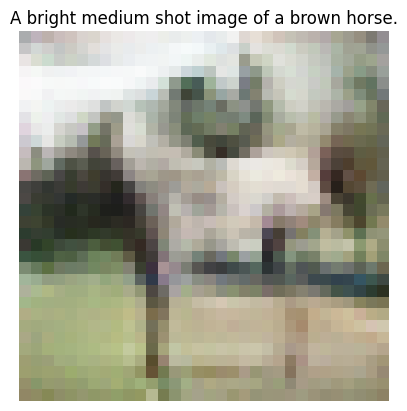

In [ ]:
# Generate sample
def generate_sample(generator, roberta_model, adapter, caption, NOISE_DIM=100):
    # set generator to evaluation code
    generator.eval()

    with torch.no_grad():
        # encoding caption and adapting embedding
        encoded_text = roberta_model.encode(caption).to(device)
        conditioned_embedding = adapter(encoded_text).to(device)
        print('conditioned_embedding shape:', conditioned_embedding.shape)

        # generating raondom noise vector
        noise = torch.randn(1, NOISE_DIM, 1, 1, device=device)
        # fake_image = generator(conditioned_embedding)
        fake_image = generator(noise, conditioned_embedding)

        # post-process
        img = fake_image[0].cpu().detach().numpy()
        img = (img * 127.5 + 127.5).astype(int)
        # img = img * 255
        img = np.transpose(img, (1, 2, 0))  # img shape [C, H, W] -> [H, W, C]

        # visualize
        plt.imshow(img)
        plt.axis('off')
        plt.title(caption)
        plt.show()

# generate one sample
generate_sample(generator, roberta_model, adapter, "A bright medium shot image of a brown horse.", NOISE_DIM)

In [ ]:
# Training code (labels/captions only)

# hyperparameters
LEARNING_RATE = 2e-4
N_EPOCHS = 50
NOISE_DIM = 100
LABEL_REAL = 1
LABEL_FAKE = 0
SAVE_INTERVAL_EPOCHS = 5

generator_k_step = 1
discriminator_k_step = 3

def GAN_training_2():
  # loading dataset
  train_dataset = CIFAR10WithCaptions(full_dataset, captions)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2)
  dataloader = train_dataloader
  fixed_caption = None

  # instantiating a generator netowrk
  generator = Generator().to(device)
  generator.apply(weights_init)

  # instantiating a discriminator netowrk
  discriminator = Discriminator().to(device)
  discriminator.apply(weights_init)

  # setting up the optimizers
  optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
  optimizer_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

  # setting criterion
  criterion = nn.BCELoss()

  # keeping track of loss values for plotting
  epoch_G_losses = []
  epoch_D_losses = []

  for epoch in range(N_EPOCHS):
      g_epoch_loss = 0.0
      d_epoch_loss = 0.0
      num_batches = 0
      pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{N_EPOCHS}]", leave=False)

      #for i, data in enumerate(dataloader, 0):
      for i, data in enumerate(pbar):
          # loading captions
          caption = data[2]
          encoded_text = roberta_model.encode(caption).to(device)
          encoded_text = adapter(encoded_text)

          wrong_caption = list(caption)
          random.shuffle(wrong_caption)
          wrong_encoded_text = roberta_model.encode(wrong_caption).to(device)
          wrong_encoded_text = adapter(wrong_encoded_text)

          # ===============================
          # updating discriminator network
          # ===============================
          # the goal is to maximize log(D(x)) + log(1 - D(G(z)))
          # training with real images
          for _ in range(discriminator_k_step):
            discriminator.zero_grad()
            real_samples = data[0].to(device)
            batch_size = real_samples.size(0)
            label = torch.full((batch_size,), LABEL_REAL, device=device)
            label = label.float()

            # for visualizing the progress of training
            if fixed_caption is None:
                FIXED_NOISE = torch.randn(128, NOISE_DIM, 1, 1, device=device)
                fixed_caption = caption
                fixed_real = real_samples

            output = discriminator(real_samples, encoded_text)
            error_discriminator_real = criterion(output, label)
            error_discriminator_real.backward(retain_graph=True)
            D_of_x = output.mean().item()

            # training with fake images
            noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
            fake = generator(noise, encoded_text)
            label.fill_(LABEL_FAKE)
            output = discriminator(fake.detach(), encoded_text)
            error_discriminator_fake = criterion(output, label)
            error_discriminator_fake.backward(retain_graph=True)

            # training with real images + wrong (mismatched) captions
            output = discriminator(real_samples, wrong_encoded_text)
            label.fill_(LABEL_FAKE)  # this is wrong pairing, so treat as fake
            error_mismatch = criterion(output, label)
            error_mismatch.backward(retain_graph=True)
            D_of_G_z1 = output.mean().item()

            #error_discriminator = error_discriminator_real + error_discriminator_fake
            error_discriminator = error_discriminator_real + error_discriminator_fake + error_mismatch
            optimizer_discriminator.step()

          # ===========================
          # updating generator network
          # ===========================
          # the goal is to maximize log(D(G(z)))
          for  _ in range(generator_k_step):
            generator.zero_grad()
            label.fill_(LABEL_REAL)
            output = discriminator(fake, encoded_text)
            error_generator = criterion(output, label)
            error_generator.backward()
            D_of_G_z2 = output.mean().item()
            optimizer_generator.step()

            # track losses
            g_epoch_loss += error_generator.item()
            d_epoch_loss += error_discriminator.item()
            num_batches += 1

          # print('[%d/%d][%d/%d] | Discriminator Loss: %.4f | Generator Loss: %.4f | D(x): %.4f | D(G(z)): %.4f / %.4f' % (epoch, N_EPOCHS, i, len(dataloader), error_discriminator.item(), error_generator.item(), D_of_x, D_of_G_z1, D_of_G_z2))

          # saving the output
          print('[%d/%d] | Discriminator Loss: %.4f | Generator Loss: %.4f | D(x): %.4f | D(G(z)): %.4f / %.4f' % (epoch, N_EPOCHS, error_discriminator.item(), error_generator.item(), D_of_x, D_of_G_z1, D_of_G_z2))
          epoch_G_losses.append(g_epoch_loss / num_batches)
          epoch_D_losses.append(d_epoch_loss / num_batches)
          if i % 100 == 0:
              print('saving the outputs')
              encoded_text = roberta_model.encode(fixed_caption).to(device)
              encoded_text = adapter(encoded_text).to(device)
              vutils.save_image(fixed_real,'outputs/real_samples.png',normalize=True)
              fake = generator(FIXED_NOISE, encoded_text)
              vutils.save_image(fake.detach(),'outputs/fake_samples_epoch_%03d.png' % (epoch),normalize=True)

  return generator, discriminator

In [ ]:
# Evaluation code
generator_2, discriminator_2 = GAN_training_2()

Epoch [1/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[0/50] | Discriminator Loss: 1.6011 | Generator Loss: 3.4272 | D(x): 0.3530 | D(G(z)): 0.3531 / 0.0369
saving the outputs
[0/50] | Discriminator Loss: 1.4875 | Generator Loss: 3.5700 | D(x): 0.4255 | D(G(z)): 0.4253 / 0.0323
[0/50] | Discriminator Loss: 1.4402 | Generator Loss: 3.9987 | D(x): 0.4846 | D(G(z)): 0.4845 / 0.0210
[0/50] | Discriminator Loss: 1.4586 | Generator Loss: 4.5885 | D(x): 0.5587 | D(G(z)): 0.5587 / 0.0119
[0/50] | Discriminator Loss: 1.5218 | Generator Loss: 4.3900 | D(x): 0.4725 | D(G(z)): 0.4724 / 0.0139
[0/50] | Discriminator Loss: 1.5221 | Generator Loss: 5.1237 | D(x): 0.6090 | D(G(z)): 0.6089 / 0.0069
[0/50] | Discriminator Loss: 1.5051 | Generator Loss: 4.8242 | D(x): 0.5394 | D(G(z)): 0.5394 / 0.0092
[0/50] | Discriminator Loss: 1.4189 | Generator Loss: 5.1961 | D(x): 0.4931 | D(G(z)): 0.4929 / 0.0063
[0/50] | Discriminator Loss: 1.4352 | Generator Loss: 5.6407 | D(x): 0.5487 | D(G(z)): 0.5486 / 0.0041
[0/50] | Discriminator Loss: 1.4111 | Generator Loss: 

Epoch [2/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[1/50] | Discriminator Loss: 1.5228 | Generator Loss: 4.3806 | D(x): 0.3387 | D(G(z)): 0.3383 / 0.0152
saving the outputs
[1/50] | Discriminator Loss: 1.4281 | Generator Loss: 4.1893 | D(x): 0.4345 | D(G(z)): 0.4337 / 0.0167
[1/50] | Discriminator Loss: 1.4947 | Generator Loss: 4.8349 | D(x): 0.6285 | D(G(z)): 0.6280 / 0.0088
[1/50] | Discriminator Loss: 1.5126 | Generator Loss: 4.5844 | D(x): 0.6348 | D(G(z)): 0.6344 / 0.0112
[1/50] | Discriminator Loss: 1.4114 | Generator Loss: 4.5366 | D(x): 0.4936 | D(G(z)): 0.4929 / 0.0117
[1/50] | Discriminator Loss: 1.4358 | Generator Loss: 4.6160 | D(x): 0.4159 | D(G(z)): 0.4153 / 0.0108
[1/50] | Discriminator Loss: 1.4256 | Generator Loss: 4.8573 | D(x): 0.5613 | D(G(z)): 0.5606 / 0.0085
[1/50] | Discriminator Loss: 1.4371 | Generator Loss: 4.3532 | D(x): 0.4190 | D(G(z)): 0.4186 / 0.0142
[1/50] | Discriminator Loss: 1.4311 | Generator Loss: 4.1918 | D(x): 0.4199 | D(G(z)): 0.4193 / 0.0168
[1/50] | Discriminator Loss: 1.5088 | Generator Loss: 

Epoch [3/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[2/50] | Discriminator Loss: 1.4324 | Generator Loss: 4.2975 | D(x): 0.4540 | D(G(z)): 0.4532 / 0.0165
saving the outputs
[2/50] | Discriminator Loss: 1.4335 | Generator Loss: 3.9552 | D(x): 0.4917 | D(G(z)): 0.4906 / 0.0227
[2/50] | Discriminator Loss: 1.4467 | Generator Loss: 3.6450 | D(x): 0.4890 | D(G(z)): 0.4871 / 0.0310
[2/50] | Discriminator Loss: 1.4145 | Generator Loss: 4.6531 | D(x): 0.4699 | D(G(z)): 0.4668 / 0.0126
[2/50] | Discriminator Loss: 1.4510 | Generator Loss: 4.3166 | D(x): 0.5676 | D(G(z)): 0.5651 / 0.0157
[2/50] | Discriminator Loss: 1.4605 | Generator Loss: 4.1399 | D(x): 0.5536 | D(G(z)): 0.5503 / 0.0183
[2/50] | Discriminator Loss: 1.4489 | Generator Loss: 4.3668 | D(x): 0.5614 | D(G(z)): 0.5588 / 0.0145
[2/50] | Discriminator Loss: 1.4041 | Generator Loss: 5.1786 | D(x): 0.5293 | D(G(z)): 0.5253 / 0.0064
[2/50] | Discriminator Loss: 1.4033 | Generator Loss: 4.7030 | D(x): 0.4746 | D(G(z)): 0.4708 / 0.0103
[2/50] | Discriminator Loss: 1.4309 | Generator Loss: 

Epoch [4/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[3/50] | Discriminator Loss: 1.2257 | Generator Loss: 5.4276 | D(x): 0.4017 | D(G(z)): 0.2569 / 0.0053
saving the outputs
[3/50] | Discriminator Loss: 1.3231 | Generator Loss: 6.8253 | D(x): 0.8385 | D(G(z)): 0.6713 / 0.0013
[3/50] | Discriminator Loss: 1.1484 | Generator Loss: 5.9357 | D(x): 0.7415 | D(G(z)): 0.5581 / 0.0032
[3/50] | Discriminator Loss: 1.1720 | Generator Loss: 6.8482 | D(x): 0.6932 | D(G(z)): 0.5346 / 0.0013
[3/50] | Discriminator Loss: 1.3987 | Generator Loss: 5.9027 | D(x): 0.3310 | D(G(z)): 0.2193 / 0.0033
[3/50] | Discriminator Loss: 1.2707 | Generator Loss: 6.0988 | D(x): 0.4554 | D(G(z)): 0.3682 / 0.0030
[3/50] | Discriminator Loss: 1.2306 | Generator Loss: 5.5301 | D(x): 0.5303 | D(G(z)): 0.4399 / 0.0049
[3/50] | Discriminator Loss: 1.2423 | Generator Loss: 5.2646 | D(x): 0.6098 | D(G(z)): 0.5157 / 0.0062
[3/50] | Discriminator Loss: 1.0692 | Generator Loss: 5.7591 | D(x): 0.5293 | D(G(z)): 0.3406 / 0.0040
[3/50] | Discriminator Loss: 1.1982 | Generator Loss: 

Epoch [5/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[4/50] | Discriminator Loss: 0.0530 | Generator Loss: 6.6785 | D(x): 0.9663 | D(G(z)): 0.0160 / 0.0017
saving the outputs
[4/50] | Discriminator Loss: 0.0330 | Generator Loss: 5.8496 | D(x): 0.9816 | D(G(z)): 0.0099 / 0.0036
[4/50] | Discriminator Loss: 0.0956 | Generator Loss: 8.3625 | D(x): 0.9230 | D(G(z)): 0.0140 / 0.0003
[4/50] | Discriminator Loss: 0.0536 | Generator Loss: 5.9130 | D(x): 0.9837 | D(G(z)): 0.0328 / 0.0034
[4/50] | Discriminator Loss: 0.1112 | Generator Loss: 4.9004 | D(x): 0.9632 | D(G(z)): 0.0557 / 0.0092
[4/50] | Discriminator Loss: 0.0801 | Generator Loss: 5.6502 | D(x): 0.9527 | D(G(z)): 0.0261 / 0.0042
[4/50] | Discriminator Loss: 0.0812 | Generator Loss: 5.2446 | D(x): 0.9545 | D(G(z)): 0.0256 / 0.0063
[4/50] | Discriminator Loss: 0.0749 | Generator Loss: 5.3610 | D(x): 0.9603 | D(G(z)): 0.0259 / 0.0055
[4/50] | Discriminator Loss: 0.0474 | Generator Loss: 6.4090 | D(x): 0.9761 | D(G(z)): 0.0201 / 0.0019
[4/50] | Discriminator Loss: 0.0693 | Generator Loss: 

Epoch [6/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[5/50] | Discriminator Loss: 0.0233 | Generator Loss: 5.6105 | D(x): 0.9870 | D(G(z)): 0.0034 / 0.0052
saving the outputs
[5/50] | Discriminator Loss: 0.0229 | Generator Loss: 9.8392 | D(x): 0.9912 | D(G(z)): 0.0137 / 0.0001
[5/50] | Discriminator Loss: 0.0409 | Generator Loss: 6.5322 | D(x): 0.9851 | D(G(z)): 0.0224 / 0.0019
[5/50] | Discriminator Loss: 0.0276 | Generator Loss: 9.8599 | D(x): 0.9795 | D(G(z)): 0.0065 / 0.0001
[5/50] | Discriminator Loss: 0.0208 | Generator Loss: 7.1126 | D(x): 0.9845 | D(G(z)): 0.0039 / 0.0011
[5/50] | Discriminator Loss: 0.0259 | Generator Loss: 6.4456 | D(x): 0.9827 | D(G(z)): 0.0027 / 0.0021
[5/50] | Discriminator Loss: 0.0291 | Generator Loss: 6.2376 | D(x): 0.9759 | D(G(z)): 0.0011 / 0.0027
[5/50] | Discriminator Loss: 0.0218 | Generator Loss: 5.1777 | D(x): 0.9911 | D(G(z)): 0.0029 / 0.0072
[5/50] | Discriminator Loss: 0.3220 | Generator Loss: 6.0639 | D(x): 0.9983 | D(G(z)): 0.2514 / 0.0033
[5/50] | Discriminator Loss: 0.0423 | Generator Loss: 

Epoch [7/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[6/50] | Discriminator Loss: 0.0427 | Generator Loss: 6.6220 | D(x): 0.9710 | D(G(z)): 0.0101 / 0.0016
saving the outputs
[6/50] | Discriminator Loss: 0.0212 | Generator Loss: 7.3159 | D(x): 0.9907 | D(G(z)): 0.0107 / 0.0008
[6/50] | Discriminator Loss: 0.0159 | Generator Loss: 5.9914 | D(x): 0.9921 | D(G(z)): 0.0043 / 0.0032
[6/50] | Discriminator Loss: 0.0127 | Generator Loss: 6.1525 | D(x): 0.9964 | D(G(z)): 0.0034 / 0.0026
[6/50] | Discriminator Loss: 0.0197 | Generator Loss: 7.5472 | D(x): 0.9889 | D(G(z)): 0.0075 / 0.0007
[6/50] | Discriminator Loss: 0.0157 | Generator Loss: 6.2229 | D(x): 0.9938 | D(G(z)): 0.0064 / 0.0025
[6/50] | Discriminator Loss: 0.0245 | Generator Loss: 6.6864 | D(x): 0.9872 | D(G(z)): 0.0085 / 0.0016
[6/50] | Discriminator Loss: 0.0183 | Generator Loss: 5.3772 | D(x): 0.9942 | D(G(z)): 0.0047 / 0.0055
[6/50] | Discriminator Loss: 0.0228 | Generator Loss: 5.3440 | D(x): 0.9902 | D(G(z)): 0.0025 / 0.0058
[6/50] | Discriminator Loss: 0.0225 | Generator Loss: 

Epoch [8/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[7/50] | Discriminator Loss: 0.0080 | Generator Loss: 11.6288 | D(x): 0.9925 | D(G(z)): 0.0004 / 0.0000
saving the outputs
[7/50] | Discriminator Loss: 0.0043 | Generator Loss: 8.4968 | D(x): 0.9994 | D(G(z)): 0.0035 / 0.0003
[7/50] | Discriminator Loss: 0.0021 | Generator Loss: 9.6313 | D(x): 0.9998 | D(G(z)): 0.0017 / 0.0001
[7/50] | Discriminator Loss: 0.0026 | Generator Loss: 9.2077 | D(x): 0.9978 | D(G(z)): 0.0003 / 0.0001
[7/50] | Discriminator Loss: 0.0021 | Generator Loss: 7.8888 | D(x): 0.9995 | D(G(z)): 0.0009 / 0.0005
[7/50] | Discriminator Loss: 0.0062 | Generator Loss: 6.7761 | D(x): 0.9992 | D(G(z)): 0.0015 / 0.0014
[7/50] | Discriminator Loss: 0.0046 | Generator Loss: 8.0366 | D(x): 0.9968 | D(G(z)): 0.0010 / 0.0004
[7/50] | Discriminator Loss: 0.0070 | Generator Loss: 6.4903 | D(x): 0.9982 | D(G(z)): 0.0022 / 0.0019
[7/50] | Discriminator Loss: 3.4697 | Generator Loss: 15.2875 | D(x): 0.9975 | D(G(z)): 0.9074 / 0.0000
[7/50] | Discriminator Loss: 3.2920 | Generator Loss

Epoch [9/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[8/50] | Discriminator Loss: 4.8796 | Generator Loss: 2.0083 | D(x): 0.0203 | D(G(z)): 0.0002 / 0.3125
saving the outputs
[8/50] | Discriminator Loss: 0.2134 | Generator Loss: 10.8584 | D(x): 0.9986 | D(G(z)): 0.1774 / 0.0000
[8/50] | Discriminator Loss: 0.0954 | Generator Loss: 9.4698 | D(x): 0.9190 | D(G(z)): 0.0075 / 0.0001
[8/50] | Discriminator Loss: 0.0320 | Generator Loss: 4.9914 | D(x): 0.9963 | D(G(z)): 0.0096 / 0.0088
[8/50] | Discriminator Loss: 0.0269 | Generator Loss: 6.3457 | D(x): 0.9801 | D(G(z)): 0.0016 / 0.0034
[8/50] | Discriminator Loss: 0.0156 | Generator Loss: 8.3157 | D(x): 0.9938 | D(G(z)): 0.0088 / 0.0003
[8/50] | Discriminator Loss: 0.0207 | Generator Loss: 6.1297 | D(x): 0.9915 | D(G(z)): 0.0080 / 0.0029
[8/50] | Discriminator Loss: 0.0467 | Generator Loss: 4.8421 | D(x): 0.9732 | D(G(z)): 0.0010 / 0.0107
[8/50] | Discriminator Loss: 0.0215 | Generator Loss: 9.6102 | D(x): 0.9817 | D(G(z)): 0.0027 / 0.0001
[8/50] | Discriminator Loss: 0.0116 | Generator Loss:

Epoch [10/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[9/50] | Discriminator Loss: 0.0356 | Generator Loss: 7.0655 | D(x): 0.9731 | D(G(z)): 0.0066 / 0.0014
saving the outputs
[9/50] | Discriminator Loss: 0.0314 | Generator Loss: 5.4563 | D(x): 0.9859 | D(G(z)): 0.0038 / 0.0059
[9/50] | Discriminator Loss: 0.0340 | Generator Loss: 6.7337 | D(x): 0.9784 | D(G(z)): 0.0099 / 0.0018
[9/50] | Discriminator Loss: 0.5162 | Generator Loss: 8.7522 | D(x): 0.6269 | D(G(z)): 0.0030 / 0.0002
[9/50] | Discriminator Loss: 0.0457 | Generator Loss: 6.5456 | D(x): 0.9986 | D(G(z)): 0.0388 / 0.0022
[9/50] | Discriminator Loss: 0.0140 | Generator Loss: 9.1376 | D(x): 0.9927 | D(G(z)): 0.0062 / 0.0002
[9/50] | Discriminator Loss: 0.1800 | Generator Loss: 6.9860 | D(x): 0.9989 | D(G(z)): 0.0463 / 0.0013
[9/50] | Discriminator Loss: 0.0272 | Generator Loss: 7.8367 | D(x): 0.9748 | D(G(z)): 0.0006 / 0.0006
[9/50] | Discriminator Loss: 0.0272 | Generator Loss: 6.0356 | D(x): 0.9816 | D(G(z)): 0.0033 / 0.0033
[9/50] | Discriminator Loss: 0.0177 | Generator Loss: 

Epoch [11/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[10/50] | Discriminator Loss: 0.0176 | Generator Loss: 7.3409 | D(x): 0.9848 | D(G(z)): 0.0010 / 0.0010
saving the outputs
[10/50] | Discriminator Loss: 0.0615 | Generator Loss: 4.7139 | D(x): 0.9880 | D(G(z)): 0.0004 / 0.0149
[10/50] | Discriminator Loss: 0.0150 | Generator Loss: 6.0863 | D(x): 0.9967 | D(G(z)): 0.0034 / 0.0038
[10/50] | Discriminator Loss: 0.0051 | Generator Loss: 9.8381 | D(x): 0.9985 | D(G(z)): 0.0035 / 0.0002
[10/50] | Discriminator Loss: 0.0195 | Generator Loss: 8.1817 | D(x): 0.9961 | D(G(z)): 0.0145 / 0.0007
[10/50] | Discriminator Loss: 0.0366 | Generator Loss: 7.4930 | D(x): 0.9666 | D(G(z)): 0.0004 / 0.0010
[10/50] | Discriminator Loss: 0.0571 | Generator Loss: 4.5072 | D(x): 0.9886 | D(G(z)): 0.0016 / 0.0180
[10/50] | Discriminator Loss: 0.0896 | Generator Loss: 10.4475 | D(x): 0.9175 | D(G(z)): 0.0002 / 0.0000
[10/50] | Discriminator Loss: 0.0062 | Generator Loss: 8.6549 | D(x): 0.9950 | D(G(z)): 0.0008 / 0.0004
[10/50] | Discriminator Loss: 0.0143 | Gener

Epoch [12/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[11/50] | Discriminator Loss: 0.0585 | Generator Loss: 8.8834 | D(x): 0.9460 | D(G(z)): 0.0001 / 0.0003
saving the outputs
[11/50] | Discriminator Loss: 0.0104 | Generator Loss: 6.0122 | D(x): 0.9987 | D(G(z)): 0.0028 / 0.0058
[11/50] | Discriminator Loss: 0.0416 | Generator Loss: 5.9415 | D(x): 0.9881 | D(G(z)): 0.0005 / 0.0044
[11/50] | Discriminator Loss: 0.0197 | Generator Loss: 6.8637 | D(x): 0.9836 | D(G(z)): 0.0007 / 0.0021
[11/50] | Discriminator Loss: 0.0186 | Generator Loss: 5.6724 | D(x): 0.9947 | D(G(z)): 0.0063 / 0.0061
[11/50] | Discriminator Loss: 0.1320 | Generator Loss: 2.1463 | D(x): 0.9999 | D(G(z)): 0.0779 / 0.2010
[11/50] | Discriminator Loss: 0.0365 | Generator Loss: 6.1348 | D(x): 0.9926 | D(G(z)): 0.0097 / 0.0041
[11/50] | Discriminator Loss: 0.0352 | Generator Loss: 5.7062 | D(x): 0.9744 | D(G(z)): 0.0019 / 0.0059
[11/50] | Discriminator Loss: 0.1891 | Generator Loss: 6.4188 | D(x): 0.9911 | D(G(z)): 0.0289 / 0.0031
[11/50] | Discriminator Loss: 0.0353 | Genera

Epoch [13/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[12/50] | Discriminator Loss: 0.0098 | Generator Loss: 10.7053 | D(x): 0.9949 | D(G(z)): 0.0046 / 0.0001
saving the outputs
[12/50] | Discriminator Loss: 0.0105 | Generator Loss: 6.6285 | D(x): 0.9980 | D(G(z)): 0.0007 / 0.0037
[12/50] | Discriminator Loss: 0.0036 | Generator Loss: 7.5628 | D(x): 0.9985 | D(G(z)): 0.0008 / 0.0011
[12/50] | Discriminator Loss: 0.1241 | Generator Loss: 7.9322 | D(x): 0.9839 | D(G(z)): 0.0001 / 0.0006
[12/50] | Discriminator Loss: 0.0093 | Generator Loss: 8.5705 | D(x): 0.9913 | D(G(z)): 0.0003 / 0.0003
[12/50] | Discriminator Loss: 0.0154 | Generator Loss: 5.6383 | D(x): 0.9966 | D(G(z)): 0.0029 / 0.0058
[12/50] | Discriminator Loss: 0.0501 | Generator Loss: 9.2603 | D(x): 0.9531 | D(G(z)): 0.0006 / 0.0002
[12/50] | Discriminator Loss: 6.6978 | Generator Loss: 9.7908 | D(x): 0.0043 | D(G(z)): 0.0000 / 0.0015
[12/50] | Discriminator Loss: 0.1380 | Generator Loss: 9.4111 | D(x): 0.8906 | D(G(z)): 0.0124 / 0.0003
[12/50] | Discriminator Loss: 0.0360 | Gener

Epoch [14/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[13/50] | Discriminator Loss: 0.0097 | Generator Loss: 8.1910 | D(x): 0.9916 | D(G(z)): 0.0007 / 0.0005
saving the outputs
[13/50] | Discriminator Loss: 0.0237 | Generator Loss: 5.2760 | D(x): 0.9896 | D(G(z)): 0.0004 / 0.0082
[13/50] | Discriminator Loss: 0.0129 | Generator Loss: 6.0353 | D(x): 0.9937 | D(G(z)): 0.0001 / 0.0041
[13/50] | Discriminator Loss: 0.0653 | Generator Loss: 5.8262 | D(x): 0.9927 | D(G(z)): 0.0002 / 0.0045
[13/50] | Discriminator Loss: 0.0138 | Generator Loss: 7.1238 | D(x): 0.9910 | D(G(z)): 0.0033 / 0.0015
[13/50] | Discriminator Loss: 0.0184 | Generator Loss: 5.5225 | D(x): 0.9948 | D(G(z)): 0.0000 / 0.0072
[13/50] | Discriminator Loss: 0.0123 | Generator Loss: 7.3675 | D(x): 0.9902 | D(G(z)): 0.0006 / 0.0010
[13/50] | Discriminator Loss: 0.0181 | Generator Loss: 5.6980 | D(x): 0.9916 | D(G(z)): 0.0000 / 0.0059
[13/50] | Discriminator Loss: 0.0140 | Generator Loss: 9.9629 | D(x): 0.9863 | D(G(z)): 0.0000 / 0.0001
[13/50] | Discriminator Loss: 0.0061 | Genera

Epoch [15/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[14/50] | Discriminator Loss: 0.0377 | Generator Loss: 5.6052 | D(x): 0.9955 | D(G(z)): 0.0008 / 0.0070
saving the outputs
[14/50] | Discriminator Loss: 0.0052 | Generator Loss: 6.9757 | D(x): 0.9991 | D(G(z)): 0.0008 / 0.0017
[14/50] | Discriminator Loss: 0.0099 | Generator Loss: 6.6887 | D(x): 0.9933 | D(G(z)): 0.0009 / 0.0021
[14/50] | Discriminator Loss: 0.0106 | Generator Loss: 6.7680 | D(x): 0.9926 | D(G(z)): 0.0011 / 0.0018
[14/50] | Discriminator Loss: 0.0210 | Generator Loss: 5.5341 | D(x): 0.9893 | D(G(z)): 0.0001 / 0.0070
[14/50] | Discriminator Loss: 0.0122 | Generator Loss: 6.6111 | D(x): 0.9917 | D(G(z)): 0.0005 / 0.0025
[14/50] | Discriminator Loss: 0.0032 | Generator Loss: 7.5084 | D(x): 0.9986 | D(G(z)): 0.0004 / 0.0012
[14/50] | Discriminator Loss: 0.0081 | Generator Loss: 8.2892 | D(x): 0.9926 | D(G(z)): 0.0000 / 0.0004
[14/50] | Discriminator Loss: 0.0149 | Generator Loss: 5.9310 | D(x): 0.9966 | D(G(z)): 0.0008 / 0.0044
[14/50] | Discriminator Loss: 0.0360 | Genera

Epoch [16/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[15/50] | Discriminator Loss: 0.0613 | Generator Loss: 5.2631 | D(x): 0.9998 | D(G(z)): 0.0050 / 0.0116
saving the outputs
[15/50] | Discriminator Loss: 0.0146 | Generator Loss: 4.4411 | D(x): 0.9969 | D(G(z)): 0.0101 / 0.0416
[15/50] | Discriminator Loss: 0.2371 | Generator Loss: 14.0823 | D(x): 0.8290 | D(G(z)): 0.0002 / 0.0000
[15/50] | Discriminator Loss: 0.0391 | Generator Loss: 5.1811 | D(x): 0.9990 | D(G(z)): 0.0218 / 0.0134
[15/50] | Discriminator Loss: 0.0412 | Generator Loss: 6.8130 | D(x): 0.9673 | D(G(z)): 0.0024 / 0.0023
[15/50] | Discriminator Loss: 0.0357 | Generator Loss: 6.8884 | D(x): 0.9787 | D(G(z)): 0.0096 / 0.0024
[15/50] | Discriminator Loss: 0.0306 | Generator Loss: 5.3460 | D(x): 0.9837 | D(G(z)): 0.0008 / 0.0099
[15/50] | Discriminator Loss: 0.0364 | Generator Loss: 5.9630 | D(x): 0.9744 | D(G(z)): 0.0012 / 0.0047
[15/50] | Discriminator Loss: 0.0229 | Generator Loss: 6.2801 | D(x): 0.9821 | D(G(z)): 0.0013 / 0.0035
[15/50] | Discriminator Loss: 0.0935 | Gener

Epoch [17/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[16/50] | Discriminator Loss: 0.0242 | Generator Loss: 8.2950 | D(x): 0.9782 | D(G(z)): 0.0012 / 0.0006
saving the outputs
[16/50] | Discriminator Loss: 0.0219 | Generator Loss: 7.7682 | D(x): 0.9795 | D(G(z)): 0.0001 / 0.0010
[16/50] | Discriminator Loss: 0.0197 | Generator Loss: 6.8601 | D(x): 0.9834 | D(G(z)): 0.0009 / 0.0019
[16/50] | Discriminator Loss: 0.0367 | Generator Loss: 5.5012 | D(x): 0.9799 | D(G(z)): 0.0018 / 0.0074
[16/50] | Discriminator Loss: 0.0238 | Generator Loss: 5.8403 | D(x): 0.9917 | D(G(z)): 0.0010 / 0.0056
[16/50] | Discriminator Loss: 0.0182 | Generator Loss: 5.8428 | D(x): 0.9868 | D(G(z)): 0.0001 / 0.0058
[16/50] | Discriminator Loss: 0.0557 | Generator Loss: 5.5104 | D(x): 0.9914 | D(G(z)): 0.0010 / 0.0076
[16/50] | Discriminator Loss: 0.0166 | Generator Loss: 7.2380 | D(x): 0.9850 | D(G(z)): 0.0004 / 0.0018
[16/50] | Discriminator Loss: 0.0200 | Generator Loss: 8.4894 | D(x): 0.9810 | D(G(z)): 0.0002 / 0.0005
[16/50] | Discriminator Loss: 0.0428 | Genera

Epoch [18/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[17/50] | Discriminator Loss: 0.0099 | Generator Loss: 6.2893 | D(x): 0.9953 | D(G(z)): 0.0012 / 0.0035
saving the outputs
[17/50] | Discriminator Loss: 0.0150 | Generator Loss: 6.1768 | D(x): 0.9909 | D(G(z)): 0.0023 / 0.0035
[17/50] | Discriminator Loss: 0.0259 | Generator Loss: 5.4165 | D(x): 0.9848 | D(G(z)): 0.0001 / 0.0082
[17/50] | Discriminator Loss: 0.1034 | Generator Loss: 7.9532 | D(x): 0.9074 | D(G(z)): 0.0000 / 0.0007
[17/50] | Discriminator Loss: 0.0103 | Generator Loss: 5.7412 | D(x): 0.9948 | D(G(z)): 0.0001 / 0.0049
[17/50] | Discriminator Loss: 0.0112 | Generator Loss: 6.1591 | D(x): 0.9948 | D(G(z)): 0.0001 / 0.0039
[17/50] | Discriminator Loss: 0.0250 | Generator Loss: 5.3583 | D(x): 0.9892 | D(G(z)): 0.0001 / 0.0080
[17/50] | Discriminator Loss: 0.0092 | Generator Loss: 7.3816 | D(x): 0.9928 | D(G(z)): 0.0002 / 0.0012
[17/50] | Discriminator Loss: 0.0555 | Generator Loss: 5.2451 | D(x): 0.9959 | D(G(z)): 0.0007 / 0.0078
[17/50] | Discriminator Loss: 0.0465 | Genera

Epoch [19/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[18/50] | Discriminator Loss: 0.0098 | Generator Loss: 8.2836 | D(x): 0.9910 | D(G(z)): 0.0001 / 0.0004
saving the outputs
[18/50] | Discriminator Loss: 0.0105 | Generator Loss: 6.6156 | D(x): 0.9936 | D(G(z)): 0.0001 / 0.0023
[18/50] | Discriminator Loss: 0.0089 | Generator Loss: 8.6383 | D(x): 0.9917 | D(G(z)): 0.0001 / 0.0004
[18/50] | Discriminator Loss: 1.9246 | Generator Loss: 13.5941 | D(x): 1.0000 | D(G(z)): 0.6520 / 0.0000
[18/50] | Discriminator Loss: 0.0081 | Generator Loss: 8.4200 | D(x): 0.9962 | D(G(z)): 0.0034 / 0.0010
[18/50] | Discriminator Loss: 0.0221 | Generator Loss: 6.4864 | D(x): 0.9965 | D(G(z)): 0.0129 / 0.0040
[18/50] | Discriminator Loss: 0.0298 | Generator Loss: 7.4898 | D(x): 0.9731 | D(G(z)): 0.0002 / 0.0014
[18/50] | Discriminator Loss: 0.0183 | Generator Loss: 8.2454 | D(x): 0.9832 | D(G(z)): 0.0003 / 0.0006
[18/50] | Discriminator Loss: 0.0269 | Generator Loss: 8.3991 | D(x): 0.9763 | D(G(z)): 0.0002 / 0.0006
[18/50] | Discriminator Loss: 0.0158 | Gener

Epoch [20/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[19/50] | Discriminator Loss: 0.0607 | Generator Loss: 4.8266 | D(x): 0.9985 | D(G(z)): 0.0012 / 0.0137
saving the outputs
[19/50] | Discriminator Loss: 0.0187 | Generator Loss: 6.2375 | D(x): 0.9917 | D(G(z)): 0.0004 / 0.0040
[19/50] | Discriminator Loss: 0.0526 | Generator Loss: 4.8046 | D(x): 0.9900 | D(G(z)): 0.0017 / 0.0124
[19/50] | Discriminator Loss: 0.0194 | Generator Loss: 6.6769 | D(x): 0.9889 | D(G(z)): 0.0026 / 0.0021
[19/50] | Discriminator Loss: 0.0191 | Generator Loss: 6.1421 | D(x): 0.9868 | D(G(z)): 0.0014 / 0.0038
[19/50] | Discriminator Loss: 0.0324 | Generator Loss: 5.1827 | D(x): 0.9834 | D(G(z)): 0.0009 / 0.0083
[19/50] | Discriminator Loss: 0.2588 | Generator Loss: 9.4710 | D(x): 0.9941 | D(G(z)): 0.0010 / 0.0001
[19/50] | Discriminator Loss: 0.0109 | Generator Loss: 7.0563 | D(x): 0.9906 | D(G(z)): 0.0001 / 0.0017
[19/50] | Discriminator Loss: 0.0077 | Generator Loss: 6.3743 | D(x): 0.9968 | D(G(z)): 0.0002 / 0.0029
[19/50] | Discriminator Loss: 0.0318 | Genera

Epoch [21/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[20/50] | Discriminator Loss: 0.0302 | Generator Loss: 7.1617 | D(x): 0.9721 | D(G(z)): 0.0001 / 0.0015
saving the outputs
[20/50] | Discriminator Loss: 0.0063 | Generator Loss: 6.0380 | D(x): 0.9963 | D(G(z)): 0.0009 / 0.0070
[20/50] | Discriminator Loss: 0.0015 | Generator Loss: 10.5639 | D(x): 0.9998 | D(G(z)): 0.0011 / 0.0001
[20/50] | Discriminator Loss: 0.0088 | Generator Loss: 8.3642 | D(x): 0.9926 | D(G(z)): 0.0010 / 0.0005
[20/50] | Discriminator Loss: 0.0237 | Generator Loss: 6.4179 | D(x): 0.9888 | D(G(z)): 0.0002 / 0.0037
[20/50] | Discriminator Loss: 0.3534 | Generator Loss: 14.5902 | D(x): 0.7887 | D(G(z)): 0.0003 / 0.0000
[20/50] | Discriminator Loss: 0.0204 | Generator Loss: 9.4540 | D(x): 0.9945 | D(G(z)): 0.0134 / 0.0003
[20/50] | Discriminator Loss: 0.0132 | Generator Loss: 9.6160 | D(x): 0.9955 | D(G(z)): 0.0083 / 0.0002
[20/50] | Discriminator Loss: 0.0203 | Generator Loss: 5.1650 | D(x): 0.9927 | D(G(z)): 0.0003 / 0.0111
[20/50] | Discriminator Loss: 0.0126 | Gene

Epoch [22/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[21/50] | Discriminator Loss: 0.2022 | Generator Loss: 6.8443 | D(x): 1.0000 | D(G(z)): 0.1596 / 0.0024
saving the outputs
[21/50] | Discriminator Loss: 0.0737 | Generator Loss: 8.2803 | D(x): 0.9355 | D(G(z)): 0.0012 / 0.0006
[21/50] | Discriminator Loss: 0.0060 | Generator Loss: 9.0764 | D(x): 0.9943 | D(G(z)): 0.0001 / 0.0002
[21/50] | Discriminator Loss: 0.0134 | Generator Loss: 6.4774 | D(x): 0.9899 | D(G(z)): 0.0001 / 0.0028
[21/50] | Discriminator Loss: 0.0260 | Generator Loss: 6.8774 | D(x): 0.9809 | D(G(z)): 0.0004 / 0.0019
[21/50] | Discriminator Loss: 0.0315 | Generator Loss: 6.8926 | D(x): 0.9729 | D(G(z)): 0.0001 / 0.0020
[21/50] | Discriminator Loss: 0.0098 | Generator Loss: 6.2152 | D(x): 0.9950 | D(G(z)): 0.0001 / 0.0035
[21/50] | Discriminator Loss: 0.0781 | Generator Loss: 4.7367 | D(x): 0.9839 | D(G(z)): 0.0001 / 0.0140
[21/50] | Discriminator Loss: 0.0367 | Generator Loss: 7.1110 | D(x): 0.9983 | D(G(z)): 0.0122 / 0.0017
[21/50] | Discriminator Loss: 0.0186 | Genera

Epoch [23/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[22/50] | Discriminator Loss: 0.0128 | Generator Loss: 6.4433 | D(x): 0.9947 | D(G(z)): 0.0000 / 0.0030
saving the outputs
[22/50] | Discriminator Loss: 0.1020 | Generator Loss: 6.1921 | D(x): 0.9924 | D(G(z)): 0.0000 / 0.0031
[22/50] | Discriminator Loss: 0.0147 | Generator Loss: 7.8989 | D(x): 0.9862 | D(G(z)): 0.0000 / 0.0007
[22/50] | Discriminator Loss: 0.0096 | Generator Loss: 5.7919 | D(x): 0.9948 | D(G(z)): 0.0000 / 0.0050
[22/50] | Discriminator Loss: 0.0197 | Generator Loss: 6.7598 | D(x): 0.9934 | D(G(z)): 0.0010 / 0.0026
[22/50] | Discriminator Loss: 0.0468 | Generator Loss: 5.5915 | D(x): 0.9899 | D(G(z)): 0.0015 / 0.0069
[22/50] | Discriminator Loss: 0.0168 | Generator Loss: 6.8179 | D(x): 0.9856 | D(G(z)): 0.0001 / 0.0021
[22/50] | Discriminator Loss: 0.0144 | Generator Loss: 7.4201 | D(x): 0.9888 | D(G(z)): 0.0007 / 0.0012
[22/50] | Discriminator Loss: 0.0169 | Generator Loss: 5.5164 | D(x): 0.9917 | D(G(z)): 0.0002 / 0.0071
[22/50] | Discriminator Loss: 0.0066 | Genera

Epoch [24/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[23/50] | Discriminator Loss: 0.0035 | Generator Loss: 8.4504 | D(x): 0.9994 | D(G(z)): 0.0024 / 0.0004
saving the outputs
[23/50] | Discriminator Loss: 0.0264 | Generator Loss: 5.4063 | D(x): 0.9940 | D(G(z)): 0.0001 / 0.0090
[23/50] | Discriminator Loss: 0.0355 | Generator Loss: 5.3006 | D(x): 0.9922 | D(G(z)): 0.0002 / 0.0087
[23/50] | Discriminator Loss: 0.0061 | Generator Loss: 8.1840 | D(x): 0.9951 | D(G(z)): 0.0006 / 0.0005
[23/50] | Discriminator Loss: 0.0310 | Generator Loss: 9.5166 | D(x): 0.9701 | D(G(z)): 0.0000 / 0.0001
[23/50] | Discriminator Loss: 0.0021 | Generator Loss: 11.9276 | D(x): 0.9997 | D(G(z)): 0.0016 / 0.0000
[23/50] | Discriminator Loss: 0.0073 | Generator Loss: 10.3181 | D(x): 0.9930 | D(G(z)): 0.0002 / 0.0001
[23/50] | Discriminator Loss: 0.0369 | Generator Loss: 5.9522 | D(x): 0.9994 | D(G(z)): 0.0245 / 0.0060
[23/50] | Discriminator Loss: 0.0608 | Generator Loss: 6.1669 | D(x): 0.9999 | D(G(z)): 0.0015 / 0.0032
[23/50] | Discriminator Loss: 0.0082 | Gene

Epoch [25/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[24/50] | Discriminator Loss: 0.0548 | Generator Loss: 3.7701 | D(x): 0.9858 | D(G(z)): 0.0316 / 0.0664
saving the outputs
[24/50] | Discriminator Loss: 0.0913 | Generator Loss: 4.9316 | D(x): 0.9557 | D(G(z)): 0.0048 / 0.0168
[24/50] | Discriminator Loss: 0.4998 | Generator Loss: 5.7399 | D(x): 0.6620 | D(G(z)): 0.0005 / 0.0061
[24/50] | Discriminator Loss: 0.0582 | Generator Loss: 4.8884 | D(x): 0.9857 | D(G(z)): 0.0042 / 0.0130
[24/50] | Discriminator Loss: 0.1174 | Generator Loss: 4.6060 | D(x): 0.9620 | D(G(z)): 0.0110 / 0.0189
[24/50] | Discriminator Loss: 0.0277 | Generator Loss: 4.3467 | D(x): 0.9948 | D(G(z)): 0.0003 / 0.0209
[24/50] | Discriminator Loss: 0.0309 | Generator Loss: 3.9282 | D(x): 0.9998 | D(G(z)): 0.0228 / 0.0455
[24/50] | Discriminator Loss: 0.0334 | Generator Loss: 5.1962 | D(x): 0.9729 | D(G(z)): 0.0012 / 0.0134
[24/50] | Discriminator Loss: 0.0221 | Generator Loss: 6.3329 | D(x): 0.9921 | D(G(z)): 0.0049 / 0.0037
[24/50] | Discriminator Loss: 0.1604 | Genera

Epoch [26/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[25/50] | Discriminator Loss: 0.0068 | Generator Loss: 7.0854 | D(x): 0.9956 | D(G(z)): 0.0001 / 0.0019
saving the outputs
[25/50] | Discriminator Loss: 0.0512 | Generator Loss: 8.5779 | D(x): 0.9989 | D(G(z)): 0.0329 / 0.0042
[25/50] | Discriminator Loss: 0.1294 | Generator Loss: 12.5429 | D(x): 0.9199 | D(G(z)): 0.0009 / 0.0000
[25/50] | Discriminator Loss: 0.0155 | Generator Loss: 9.8172 | D(x): 0.9963 | D(G(z)): 0.0110 / 0.0003
[25/50] | Discriminator Loss: 0.0084 | Generator Loss: 7.2505 | D(x): 0.9995 | D(G(z)): 0.0021 / 0.0027
[25/50] | Discriminator Loss: 0.0066 | Generator Loss: 7.8980 | D(x): 0.9952 | D(G(z)): 0.0006 / 0.0011
[25/50] | Discriminator Loss: 0.0055 | Generator Loss: 8.1919 | D(x): 0.9958 | D(G(z)): 0.0003 / 0.0009
[25/50] | Discriminator Loss: 0.0156 | Generator Loss: 6.1391 | D(x): 0.9956 | D(G(z)): 0.0003 / 0.0046
[25/50] | Discriminator Loss: 0.0112 | Generator Loss: 11.7896 | D(x): 0.9892 | D(G(z)): 0.0002 / 0.0000
[25/50] | Discriminator Loss: 0.0037 | Gene

Epoch [27/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[26/50] | Discriminator Loss: 0.0363 | Generator Loss: 9.3224 | D(x): 0.9659 | D(G(z)): 0.0000 / 0.0002
saving the outputs
[26/50] | Discriminator Loss: 0.0068 | Generator Loss: 6.9629 | D(x): 0.9953 | D(G(z)): 0.0003 / 0.0023
[26/50] | Discriminator Loss: 0.0359 | Generator Loss: 6.7241 | D(x): 0.9699 | D(G(z)): 0.0000 / 0.0031
[26/50] | Discriminator Loss: 0.1894 | Generator Loss: 6.5855 | D(x): 0.9985 | D(G(z)): 0.0018 / 0.0032
[26/50] | Discriminator Loss: 0.0256 | Generator Loss: 10.0149 | D(x): 0.9772 | D(G(z)): 0.0016 / 0.0001
[26/50] | Discriminator Loss: 0.0085 | Generator Loss: 8.1831 | D(x): 0.9922 | D(G(z)): 0.0001 / 0.0006
[26/50] | Discriminator Loss: 0.0109 | Generator Loss: 6.2213 | D(x): 0.9936 | D(G(z)): 0.0001 / 0.0041
[26/50] | Discriminator Loss: 0.0489 | Generator Loss: 4.8634 | D(x): 0.9920 | D(G(z)): 0.0001 / 0.0131
[26/50] | Discriminator Loss: 0.0494 | Generator Loss: 5.2338 | D(x): 0.9908 | D(G(z)): 0.0015 / 0.0098
[26/50] | Discriminator Loss: 0.0697 | Gener

Epoch [28/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[27/50] | Discriminator Loss: 0.0099 | Generator Loss: 6.4116 | D(x): 0.9954 | D(G(z)): 0.0004 / 0.0040
saving the outputs
[27/50] | Discriminator Loss: 0.0066 | Generator Loss: 8.0263 | D(x): 0.9947 | D(G(z)): 0.0002 / 0.0007
[27/50] | Discriminator Loss: 0.0157 | Generator Loss: 7.5211 | D(x): 0.9894 | D(G(z)): 0.0000 / 0.0013
[27/50] | Discriminator Loss: 0.0304 | Generator Loss: 5.6436 | D(x): 0.9970 | D(G(z)): 0.0005 / 0.0063
[27/50] | Discriminator Loss: 0.0215 | Generator Loss: 6.3922 | D(x): 0.9903 | D(G(z)): 0.0030 / 0.0036
[27/50] | Discriminator Loss: 0.0124 | Generator Loss: 6.7796 | D(x): 0.9948 | D(G(z)): 0.0047 / 0.0023
[27/50] | Discriminator Loss: 0.0138 | Generator Loss: 6.8737 | D(x): 0.9885 | D(G(z)): 0.0001 / 0.0022
[27/50] | Discriminator Loss: 0.0144 | Generator Loss: 5.8763 | D(x): 0.9949 | D(G(z)): 0.0006 / 0.0047
[27/50] | Discriminator Loss: 0.1103 | Generator Loss: 8.5046 | D(x): 0.9927 | D(G(z)): 0.0001 / 0.0003
[27/50] | Discriminator Loss: 0.0118 | Genera

Epoch [29/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[28/50] | Discriminator Loss: 0.0097 | Generator Loss: 6.3375 | D(x): 0.9968 | D(G(z)): 0.0004 / 0.0038
saving the outputs
[28/50] | Discriminator Loss: 0.0139 | Generator Loss: 5.8677 | D(x): 0.9937 | D(G(z)): 0.0001 / 0.0046
[28/50] | Discriminator Loss: 0.2235 | Generator Loss: 10.9403 | D(x): 0.9996 | D(G(z)): 0.0010 / 0.0000
[28/50] | Discriminator Loss: 0.0062 | Generator Loss: 6.7455 | D(x): 1.0000 | D(G(z)): 0.0025 / 0.0040
[28/50] | Discriminator Loss: 0.0466 | Generator Loss: 11.6041 | D(x): 0.9569 | D(G(z)): 0.0003 / 0.0000
[28/50] | Discriminator Loss: 0.0051 | Generator Loss: 7.0371 | D(x): 0.9978 | D(G(z)): 0.0006 / 0.0021
[28/50] | Discriminator Loss: 0.0043 | Generator Loss: 7.0780 | D(x): 0.9980 | D(G(z)): 0.0001 / 0.0018
[28/50] | Discriminator Loss: 0.0098 | Generator Loss: 8.7590 | D(x): 0.9936 | D(G(z)): 0.0029 / 0.0003
[28/50] | Discriminator Loss: 0.0316 | Generator Loss: 8.6075 | D(x): 0.9701 | D(G(z)): 0.0000 / 0.0003
[28/50] | Discriminator Loss: 0.0105 | Gene

Epoch [30/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[29/50] | Discriminator Loss: 0.0106 | Generator Loss: 6.9212 | D(x): 0.9926 | D(G(z)): 0.0004 / 0.0026
saving the outputs
[29/50] | Discriminator Loss: 0.0154 | Generator Loss: 6.8915 | D(x): 0.9898 | D(G(z)): 0.0002 / 0.0025
[29/50] | Discriminator Loss: 0.0215 | Generator Loss: 5.6672 | D(x): 0.9968 | D(G(z)): 0.0004 / 0.0070
[29/50] | Discriminator Loss: 0.0313 | Generator Loss: 5.2737 | D(x): 0.9982 | D(G(z)): 0.0001 / 0.0088
[29/50] | Discriminator Loss: 0.0044 | Generator Loss: 8.7481 | D(x): 0.9962 | D(G(z)): 0.0001 / 0.0003
[29/50] | Discriminator Loss: 0.0116 | Generator Loss: 6.5123 | D(x): 0.9943 | D(G(z)): 0.0023 / 0.0028
[29/50] | Discriminator Loss: 0.0151 | Generator Loss: 5.3911 | D(x): 0.9967 | D(G(z)): 0.0001 / 0.0086
[29/50] | Discriminator Loss: 0.0206 | Generator Loss: 7.5521 | D(x): 0.9810 | D(G(z)): 0.0001 / 0.0010
[29/50] | Discriminator Loss: 0.0496 | Generator Loss: 5.8842 | D(x): 0.9927 | D(G(z)): 0.0010 / 0.0048
[29/50] | Discriminator Loss: 0.0185 | Genera

Epoch [31/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[30/50] | Discriminator Loss: 0.0248 | Generator Loss: 11.1940 | D(x): 0.9780 | D(G(z)): 0.0021 / 0.0000
saving the outputs
[30/50] | Discriminator Loss: 0.0034 | Generator Loss: 8.4009 | D(x): 0.9981 | D(G(z)): 0.0011 / 0.0006
[30/50] | Discriminator Loss: 0.0043 | Generator Loss: 7.1459 | D(x): 0.9971 | D(G(z)): 0.0000 / 0.0015
[30/50] | Discriminator Loss: 0.0044 | Generator Loss: 8.1029 | D(x): 0.9998 | D(G(z)): 0.0027 / 0.0007
[30/50] | Discriminator Loss: 0.0044 | Generator Loss: 7.2803 | D(x): 0.9970 | D(G(z)): 0.0000 / 0.0013
[30/50] | Discriminator Loss: 0.0773 | Generator Loss: 7.7775 | D(x): 0.9968 | D(G(z)): 0.0001 / 0.0007
[30/50] | Discriminator Loss: 0.0075 | Generator Loss: 9.8284 | D(x): 0.9927 | D(G(z)): 0.0000 / 0.0002
[30/50] | Discriminator Loss: 0.0033 | Generator Loss: 8.4888 | D(x): 0.9975 | D(G(z)): 0.0002 / 0.0007
[30/50] | Discriminator Loss: 0.0070 | Generator Loss: 6.5137 | D(x): 0.9997 | D(G(z)): 0.0012 / 0.0031
[30/50] | Discriminator Loss: 0.0049 | Gener

Epoch [32/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[31/50] | Discriminator Loss: 0.0422 | Generator Loss: 5.3899 | D(x): 0.9993 | D(G(z)): 0.0085 / 0.0106
saving the outputs
[31/50] | Discriminator Loss: 0.0442 | Generator Loss: 7.0170 | D(x): 0.9617 | D(G(z)): 0.0001 / 0.0023
[31/50] | Discriminator Loss: 0.0211 | Generator Loss: 5.3113 | D(x): 0.9919 | D(G(z)): 0.0013 / 0.0116
[31/50] | Discriminator Loss: 0.0706 | Generator Loss: 6.0813 | D(x): 0.9430 | D(G(z)): 0.0003 / 0.0046
[31/50] | Discriminator Loss: 0.0368 | Generator Loss: 5.7597 | D(x): 0.9744 | D(G(z)): 0.0005 / 0.0069
[31/50] | Discriminator Loss: 0.0548 | Generator Loss: 5.3407 | D(x): 0.9701 | D(G(z)): 0.0000 / 0.0110
[31/50] | Discriminator Loss: 0.0629 | Generator Loss: 4.6586 | D(x): 0.9863 | D(G(z)): 0.0041 / 0.0160
[31/50] | Discriminator Loss: 0.0299 | Generator Loss: 5.7422 | D(x): 0.9764 | D(G(z)): 0.0000 / 0.0060
[31/50] | Discriminator Loss: 0.0186 | Generator Loss: 8.4222 | D(x): 0.9836 | D(G(z)): 0.0001 / 0.0005
[31/50] | Discriminator Loss: 0.0220 | Genera

Epoch [33/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[32/50] | Discriminator Loss: 0.0081 | Generator Loss: 5.6223 | D(x): 0.9993 | D(G(z)): 0.0024 / 0.0063
saving the outputs
[32/50] | Discriminator Loss: 0.0208 | Generator Loss: 7.6702 | D(x): 0.9814 | D(G(z)): 0.0007 / 0.0009
[32/50] | Discriminator Loss: 0.0050 | Generator Loss: 6.8523 | D(x): 0.9974 | D(G(z)): 0.0001 / 0.0020
[32/50] | Discriminator Loss: 0.0047 | Generator Loss: 7.5848 | D(x): 0.9980 | D(G(z)): 0.0010 / 0.0009
[32/50] | Discriminator Loss: 0.0211 | Generator Loss: 5.5733 | D(x): 0.9892 | D(G(z)): 0.0002 / 0.0060
[32/50] | Discriminator Loss: 0.0079 | Generator Loss: 8.1336 | D(x): 0.9931 | D(G(z)): 0.0002 / 0.0006
[32/50] | Discriminator Loss: 0.0037 | Generator Loss: 6.7450 | D(x): 0.9998 | D(G(z)): 0.0004 / 0.0020
[32/50] | Discriminator Loss: 0.0036 | Generator Loss: 7.5890 | D(x): 0.9976 | D(G(z)): 0.0001 / 0.0010
[32/50] | Discriminator Loss: 0.0174 | Generator Loss: 7.8193 | D(x): 0.9835 | D(G(z)): 0.0001 / 0.0008
[32/50] | Discriminator Loss: 0.2111 | Genera

Epoch [34/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[33/50] | Discriminator Loss: 0.0926 | Generator Loss: 4.3749 | D(x): 0.9581 | D(G(z)): 0.0004 / 0.0269
saving the outputs
[33/50] | Discriminator Loss: 0.2010 | Generator Loss: 4.7703 | D(x): 0.9337 | D(G(z)): 0.0018 / 0.0152
[33/50] | Discriminator Loss: 0.2460 | Generator Loss: 6.1184 | D(x): 0.9887 | D(G(z)): 0.0008 / 0.0037
[33/50] | Discriminator Loss: 0.0603 | Generator Loss: 4.6495 | D(x): 0.9969 | D(G(z)): 0.0024 / 0.0199
[33/50] | Discriminator Loss: 0.0224 | Generator Loss: 6.4239 | D(x): 0.9802 | D(G(z)): 0.0006 / 0.0036
[33/50] | Discriminator Loss: 0.0306 | Generator Loss: 5.9104 | D(x): 0.9795 | D(G(z)): 0.0015 / 0.0059
[33/50] | Discriminator Loss: 0.0418 | Generator Loss: 5.7135 | D(x): 0.9679 | D(G(z)): 0.0003 / 0.0073
[33/50] | Discriminator Loss: 0.0423 | Generator Loss: 6.9286 | D(x): 0.9617 | D(G(z)): 0.0009 / 0.0022
[33/50] | Discriminator Loss: 0.0574 | Generator Loss: 6.6496 | D(x): 0.9508 | D(G(z)): 0.0004 / 0.0028
[33/50] | Discriminator Loss: 0.0263 | Genera

Epoch [35/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[34/50] | Discriminator Loss: 0.0135 | Generator Loss: 9.0753 | D(x): 0.9876 | D(G(z)): 0.0007 / 0.0002
saving the outputs
[34/50] | Discriminator Loss: 0.0167 | Generator Loss: 5.2849 | D(x): 0.9951 | D(G(z)): 0.0007 / 0.0077
[34/50] | Discriminator Loss: 0.0073 | Generator Loss: 6.2312 | D(x): 0.9994 | D(G(z)): 0.0004 / 0.0040
[34/50] | Discriminator Loss: 0.0052 | Generator Loss: 7.3274 | D(x): 0.9977 | D(G(z)): 0.0008 / 0.0012
[34/50] | Discriminator Loss: 0.0260 | Generator Loss: 5.3898 | D(x): 0.9978 | D(G(z)): 0.0001 / 0.0074
[34/50] | Discriminator Loss: 0.0064 | Generator Loss: 8.0099 | D(x): 0.9943 | D(G(z)): 0.0000 / 0.0007
[34/50] | Discriminator Loss: 0.0038 | Generator Loss: 6.8096 | D(x): 0.9984 | D(G(z)): 0.0002 / 0.0019
[34/50] | Discriminator Loss: 0.0085 | Generator Loss: 5.8532 | D(x): 0.9964 | D(G(z)): 0.0000 / 0.0050
[34/50] | Discriminator Loss: 0.0041 | Generator Loss: 8.7771 | D(x): 0.9963 | D(G(z)): 0.0000 / 0.0003
[34/50] | Discriminator Loss: 0.0264 | Genera

Epoch [36/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[35/50] | Discriminator Loss: 0.0049 | Generator Loss: 8.8146 | D(x): 0.9955 | D(G(z)): 0.0002 / 0.0003
saving the outputs
[35/50] | Discriminator Loss: 0.0030 | Generator Loss: 8.3203 | D(x): 0.9980 | D(G(z)): 0.0004 / 0.0005
[35/50] | Discriminator Loss: 0.0166 | Generator Loss: 5.8783 | D(x): 0.9933 | D(G(z)): 0.0001 / 0.0053
[35/50] | Discriminator Loss: 0.0124 | Generator Loss: 6.7722 | D(x): 0.9907 | D(G(z)): 0.0002 / 0.0022
[35/50] | Discriminator Loss: 0.0083 | Generator Loss: 5.6481 | D(x): 0.9983 | D(G(z)): 0.0012 / 0.0070
[35/50] | Discriminator Loss: 0.0161 | Generator Loss: 5.0001 | D(x): 0.9931 | D(G(z)): 0.0009 / 0.0413
[35/50] | Discriminator Loss: 0.0297 | Generator Loss: 9.8155 | D(x): 0.9732 | D(G(z)): 0.0003 / 0.0011
[35/50] | Discriminator Loss: 0.0079 | Generator Loss: 10.9864 | D(x): 0.9928 | D(G(z)): 0.0005 / 0.0001
[35/50] | Discriminator Loss: 0.1938 | Generator Loss: 5.8712 | D(x): 0.9995 | D(G(z)): 0.0105 / 0.0055
[35/50] | Discriminator Loss: 0.0096 | Gener

Epoch [37/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[36/50] | Discriminator Loss: 0.0021 | Generator Loss: 10.0119 | D(x): 0.9982 | D(G(z)): 0.0002 / 0.0005
saving the outputs
[36/50] | Discriminator Loss: 0.0235 | Generator Loss: 5.7999 | D(x): 0.9994 | D(G(z)): 0.0115 / 0.0073
[36/50] | Discriminator Loss: 0.0106 | Generator Loss: 7.1807 | D(x): 0.9922 | D(G(z)): 0.0001 / 0.0016
[36/50] | Discriminator Loss: 0.0060 | Generator Loss: 7.8971 | D(x): 0.9948 | D(G(z)): 0.0001 / 0.0007
[36/50] | Discriminator Loss: 0.0039 | Generator Loss: 7.0465 | D(x): 0.9991 | D(G(z)): 0.0010 / 0.0016
[36/50] | Discriminator Loss: 0.0040 | Generator Loss: 9.3490 | D(x): 0.9967 | D(G(z)): 0.0002 / 0.0002
[36/50] | Discriminator Loss: 0.0053 | Generator Loss: 8.3163 | D(x): 0.9952 | D(G(z)): 0.0001 / 0.0005
[36/50] | Discriminator Loss: 0.0075 | Generator Loss: 5.8963 | D(x): 0.9970 | D(G(z)): 0.0005 / 0.0048
[36/50] | Discriminator Loss: 0.0065 | Generator Loss: 6.6770 | D(x): 0.9982 | D(G(z)): 0.0001 / 0.0022
[36/50] | Discriminator Loss: 0.0204 | Gener

Epoch [38/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[37/50] | Discriminator Loss: 0.0188 | Generator Loss: 6.4471 | D(x): 0.9880 | D(G(z)): 0.0004 / 0.0032
saving the outputs
[37/50] | Discriminator Loss: 0.0322 | Generator Loss: 5.3990 | D(x): 0.9935 | D(G(z)): 0.0001 / 0.0074
[37/50] | Discriminator Loss: 0.0033 | Generator Loss: 8.3262 | D(x): 0.9975 | D(G(z)): 0.0002 / 0.0005
[37/50] | Discriminator Loss: 0.0085 | Generator Loss: 5.8610 | D(x): 0.9964 | D(G(z)): 0.0001 / 0.0053
[37/50] | Discriminator Loss: 0.0243 | Generator Loss: 5.3969 | D(x): 0.9939 | D(G(z)): 0.0001 / 0.0073
[37/50] | Discriminator Loss: 0.0106 | Generator Loss: 9.2491 | D(x): 0.9898 | D(G(z)): 0.0001 / 0.0002
[37/50] | Discriminator Loss: 0.0078 | Generator Loss: 7.2615 | D(x): 0.9935 | D(G(z)): 0.0001 / 0.0012
[37/50] | Discriminator Loss: 0.0122 | Generator Loss: 5.9204 | D(x): 0.9963 | D(G(z)): 0.0010 / 0.0048
[37/50] | Discriminator Loss: 0.0222 | Generator Loss: 5.8307 | D(x): 0.9868 | D(G(z)): 0.0000 / 0.0047
[37/50] | Discriminator Loss: 0.0078 | Genera

Epoch [39/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[38/50] | Discriminator Loss: 0.0141 | Generator Loss: 5.4951 | D(x): 0.9978 | D(G(z)): 0.0002 / 0.0062
saving the outputs
[38/50] | Discriminator Loss: 0.0161 | Generator Loss: 5.5471 | D(x): 0.9956 | D(G(z)): 0.0001 / 0.0069
[38/50] | Discriminator Loss: 0.0128 | Generator Loss: 6.0730 | D(x): 0.9914 | D(G(z)): 0.0001 / 0.0039
[38/50] | Discriminator Loss: 0.0082 | Generator Loss: 8.9786 | D(x): 0.9920 | D(G(z)): 0.0000 / 0.0002
[38/50] | Discriminator Loss: 0.0389 | Generator Loss: 5.1094 | D(x): 0.9964 | D(G(z)): 0.0042 / 0.0111
[38/50] | Discriminator Loss: 0.0112 | Generator Loss: 8.4041 | D(x): 0.9900 | D(G(z)): 0.0005 / 0.0004
[38/50] | Discriminator Loss: 0.0105 | Generator Loss: 5.6433 | D(x): 0.9956 | D(G(z)): 0.0000 / 0.0061
[38/50] | Discriminator Loss: 0.0042 | Generator Loss: 7.4381 | D(x): 0.9981 | D(G(z)): 0.0010 / 0.0010
[38/50] | Discriminator Loss: 0.0097 | Generator Loss: 6.0486 | D(x): 0.9953 | D(G(z)): 0.0003 / 0.0043
[38/50] | Discriminator Loss: 0.0112 | Genera

Epoch [40/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[39/50] | Discriminator Loss: 0.0150 | Generator Loss: 6.2472 | D(x): 0.9900 | D(G(z)): 0.0001 / 0.0037
saving the outputs
[39/50] | Discriminator Loss: 0.0258 | Generator Loss: 5.7100 | D(x): 0.9983 | D(G(z)): 0.0002 / 0.0057
[39/50] | Discriminator Loss: 0.0187 | Generator Loss: 6.5866 | D(x): 0.9851 | D(G(z)): 0.0000 / 0.0025
[39/50] | Discriminator Loss: 0.0042 | Generator Loss: 7.2518 | D(x): 0.9973 | D(G(z)): 0.0000 / 0.0014
[39/50] | Discriminator Loss: 0.0040 | Generator Loss: 7.2433 | D(x): 0.9997 | D(G(z)): 0.0004 / 0.0013
[39/50] | Discriminator Loss: 0.0077 | Generator Loss: 8.1329 | D(x): 0.9932 | D(G(z)): 0.0000 / 0.0006
[39/50] | Discriminator Loss: 0.0058 | Generator Loss: 7.3303 | D(x): 0.9955 | D(G(z)): 0.0000 / 0.0015
[39/50] | Discriminator Loss: 0.0153 | Generator Loss: 5.4119 | D(x): 0.9964 | D(G(z)): 0.0005 / 0.0070
[39/50] | Discriminator Loss: 0.0056 | Generator Loss: 8.8252 | D(x): 0.9948 | D(G(z)): 0.0001 / 0.0003
[39/50] | Discriminator Loss: 0.0276 | Genera

Epoch [41/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[40/50] | Discriminator Loss: 0.0291 | Generator Loss: 6.1439 | D(x): 0.9811 | D(G(z)): 0.0001 / 0.0046
saving the outputs
[40/50] | Discriminator Loss: 0.0149 | Generator Loss: 6.0924 | D(x): 0.9909 | D(G(z)): 0.0007 / 0.0045
[40/50] | Discriminator Loss: 0.0369 | Generator Loss: 9.6701 | D(x): 0.9658 | D(G(z)): 0.0001 / 0.0002
[40/50] | Discriminator Loss: 0.0033 | Generator Loss: 8.1161 | D(x): 0.9973 | D(G(z)): 0.0001 / 0.0007
[40/50] | Discriminator Loss: 0.0106 | Generator Loss: 6.6194 | D(x): 0.9923 | D(G(z)): 0.0000 / 0.0023
[40/50] | Discriminator Loss: 0.0251 | Generator Loss: 5.6585 | D(x): 0.9846 | D(G(z)): 0.0000 / 0.0059
[40/50] | Discriminator Loss: 0.0283 | Generator Loss: 5.2054 | D(x): 0.9922 | D(G(z)): 0.0002 / 0.0106
[40/50] | Discriminator Loss: 0.0204 | Generator Loss: 6.0739 | D(x): 0.9854 | D(G(z)): 0.0000 / 0.0047
[40/50] | Discriminator Loss: 0.0108 | Generator Loss: 7.0229 | D(x): 0.9912 | D(G(z)): 0.0000 / 0.0017
[40/50] | Discriminator Loss: 0.0062 | Genera

Epoch [42/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[41/50] | Discriminator Loss: 0.0642 | Generator Loss: 7.4177 | D(x): 0.9996 | D(G(z)): 0.0009 / 0.0011
saving the outputs
[41/50] | Discriminator Loss: 0.0113 | Generator Loss: 9.0146 | D(x): 0.9898 | D(G(z)): 0.0007 / 0.0003
[41/50] | Discriminator Loss: 0.0125 | Generator Loss: 6.5770 | D(x): 0.9967 | D(G(z)): 0.0055 / 0.0028
[41/50] | Discriminator Loss: 0.0055 | Generator Loss: 7.6945 | D(x): 0.9954 | D(G(z)): 0.0001 / 0.0009
[41/50] | Discriminator Loss: 0.0553 | Generator Loss: 6.0293 | D(x): 0.9932 | D(G(z)): 0.0003 / 0.0042
[41/50] | Discriminator Loss: 0.0181 | Generator Loss: 5.7054 | D(x): 0.9904 | D(G(z)): 0.0000 / 0.0065
[41/50] | Discriminator Loss: 0.0289 | Generator Loss: 5.3384 | D(x): 0.9937 | D(G(z)): 0.0005 / 0.0089
[41/50] | Discriminator Loss: 0.0109 | Generator Loss: 6.3579 | D(x): 0.9931 | D(G(z)): 0.0001 / 0.0032
[41/50] | Discriminator Loss: 0.0168 | Generator Loss: 6.9437 | D(x): 0.9858 | D(G(z)): 0.0000 / 0.0019
[41/50] | Discriminator Loss: 0.0126 | Genera

Epoch [43/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[42/50] | Discriminator Loss: 0.0275 | Generator Loss: 5.7143 | D(x): 0.9829 | D(G(z)): 0.0002 / 0.0055
saving the outputs
[42/50] | Discriminator Loss: 0.0995 | Generator Loss: 6.5186 | D(x): 0.9988 | D(G(z)): 0.0014 / 0.0025
[42/50] | Discriminator Loss: 0.0058 | Generator Loss: 7.6258 | D(x): 0.9965 | D(G(z)): 0.0001 / 0.0015
[42/50] | Discriminator Loss: 0.0049 | Generator Loss: 11.0694 | D(x): 0.9962 | D(G(z)): 0.0010 / 0.0000
[42/50] | Discriminator Loss: 0.0046 | Generator Loss: 9.4173 | D(x): 0.9962 | D(G(z)): 0.0005 / 0.0002
[42/50] | Discriminator Loss: 0.0125 | Generator Loss: 5.7725 | D(x): 0.9953 | D(G(z)): 0.0001 / 0.0064
[42/50] | Discriminator Loss: 0.0114 | Generator Loss: 6.1926 | D(x): 0.9946 | D(G(z)): 0.0002 / 0.0034
[42/50] | Discriminator Loss: 0.0070 | Generator Loss: 6.5277 | D(x): 0.9967 | D(G(z)): 0.0004 / 0.0024
[42/50] | Discriminator Loss: 0.0059 | Generator Loss: 7.5836 | D(x): 0.9948 | D(G(z)): 0.0000 / 0.0009
[42/50] | Discriminator Loss: 0.0043 | Gener

Epoch [44/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[43/50] | Discriminator Loss: 0.0047 | Generator Loss: 6.6566 | D(x): 0.9983 | D(G(z)): 0.0001 / 0.0023
saving the outputs
[43/50] | Discriminator Loss: 0.0043 | Generator Loss: 8.5276 | D(x): 0.9960 | D(G(z)): 0.0000 / 0.0004
[43/50] | Discriminator Loss: 0.0070 | Generator Loss: 6.4989 | D(x): 0.9960 | D(G(z)): 0.0002 / 0.0028
[43/50] | Discriminator Loss: 0.0103 | Generator Loss: 7.0074 | D(x): 0.9918 | D(G(z)): 0.0000 / 0.0016
[43/50] | Discriminator Loss: 0.0173 | Generator Loss: 5.4191 | D(x): 0.9955 | D(G(z)): 0.0002 / 0.0077
[43/50] | Discriminator Loss: 0.0043 | Generator Loss: 6.5450 | D(x): 0.9993 | D(G(z)): 0.0004 / 0.0025
[43/50] | Discriminator Loss: 0.0106 | Generator Loss: 5.3718 | D(x): 0.9966 | D(G(z)): 0.0001 / 0.0072
[43/50] | Discriminator Loss: 0.0201 | Generator Loss: 8.1553 | D(x): 0.9814 | D(G(z)): 0.0001 / 0.0006
[43/50] | Discriminator Loss: 0.0033 | Generator Loss: 8.2158 | D(x): 0.9973 | D(G(z)): 0.0001 / 0.0005
[43/50] | Discriminator Loss: 0.0028 | Genera

Epoch [45/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[44/50] | Discriminator Loss: 0.0103 | Generator Loss: 6.8262 | D(x): 0.9924 | D(G(z)): 0.0003 / 0.0022
saving the outputs
[44/50] | Discriminator Loss: 0.0304 | Generator Loss: 5.5491 | D(x): 0.9987 | D(G(z)): 0.0003 / 0.0072
[44/50] | Discriminator Loss: 0.0138 | Generator Loss: 6.3004 | D(x): 0.9918 | D(G(z)): 0.0001 / 0.0037
[44/50] | Discriminator Loss: 0.0063 | Generator Loss: 6.6451 | D(x): 0.9967 | D(G(z)): 0.0000 / 0.0029
[44/50] | Discriminator Loss: 0.0154 | Generator Loss: 7.5785 | D(x): 0.9868 | D(G(z)): 0.0002 / 0.0011
[44/50] | Discriminator Loss: 0.0054 | Generator Loss: 8.4822 | D(x): 0.9952 | D(G(z)): 0.0001 / 0.0006
[44/50] | Discriminator Loss: 0.0132 | Generator Loss: 5.6822 | D(x): 0.9942 | D(G(z)): 0.0003 / 0.0057
[44/50] | Discriminator Loss: 0.0094 | Generator Loss: 7.8556 | D(x): 0.9918 | D(G(z)): 0.0000 / 0.0008
[44/50] | Discriminator Loss: 0.0125 | Generator Loss: 7.9728 | D(x): 0.9884 | D(G(z)): 0.0000 / 0.0007
[44/50] | Discriminator Loss: 0.0926 | Genera

Epoch [46/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[45/50] | Discriminator Loss: 11.0366 | Generator Loss: 9.8290 | D(x): 0.0097 | D(G(z)): 0.0001 / 0.0576
saving the outputs
[45/50] | Discriminator Loss: 1.5120 | Generator Loss: 7.1345 | D(x): 0.7440 | D(G(z)): 0.1911 / 0.0075
[45/50] | Discriminator Loss: 0.8340 | Generator Loss: 5.8130 | D(x): 0.5813 | D(G(z)): 0.0019 / 0.0109
[45/50] | Discriminator Loss: 0.2833 | Generator Loss: 7.7000 | D(x): 0.7836 | D(G(z)): 0.0019 / 0.0009
[45/50] | Discriminator Loss: 0.0412 | Generator Loss: 5.4910 | D(x): 0.9891 | D(G(z)): 0.0045 / 0.0067
[45/50] | Discriminator Loss: 0.1417 | Generator Loss: 3.9897 | D(x): 0.8990 | D(G(z)): 0.0002 / 0.0271
[45/50] | Discriminator Loss: 0.3552 | Generator Loss: 6.6273 | D(x): 0.9887 | D(G(z)): 0.0115 / 0.0021
[45/50] | Discriminator Loss: 0.0832 | Generator Loss: 4.8531 | D(x): 0.9906 | D(G(z)): 0.0205 / 0.0132
[45/50] | Discriminator Loss: 0.0770 | Generator Loss: 3.9115 | D(x): 0.9542 | D(G(z)): 0.0023 / 0.0302
[45/50] | Discriminator Loss: 0.1343 | Gener

Epoch [47/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[46/50] | Discriminator Loss: 0.0731 | Generator Loss: 9.6847 | D(x): 0.9316 | D(G(z)): 0.0002 / 0.0003
saving the outputs
[46/50] | Discriminator Loss: 0.0119 | Generator Loss: 5.6317 | D(x): 0.9997 | D(G(z)): 0.0022 / 0.0096
[46/50] | Discriminator Loss: 0.0343 | Generator Loss: 8.7443 | D(x): 0.9677 | D(G(z)): 0.0001 / 0.0004
[46/50] | Discriminator Loss: 0.0027 | Generator Loss: 9.2372 | D(x): 0.9976 | D(G(z)): 0.0001 / 0.0003
[46/50] | Discriminator Loss: 0.0074 | Generator Loss: 6.9044 | D(x): 0.9957 | D(G(z)): 0.0004 / 0.0026
[46/50] | Discriminator Loss: 0.0133 | Generator Loss: 6.3941 | D(x): 0.9912 | D(G(z)): 0.0001 / 0.0034
[46/50] | Discriminator Loss: 0.0313 | Generator Loss: 7.9646 | D(x): 0.9720 | D(G(z)): 0.0001 / 0.0010
[46/50] | Discriminator Loss: 0.0083 | Generator Loss: 6.4769 | D(x): 0.9952 | D(G(z)): 0.0003 / 0.0032
[46/50] | Discriminator Loss: 0.0188 | Generator Loss: 5.5201 | D(x): 0.9954 | D(G(z)): 0.0001 / 0.0079
[46/50] | Discriminator Loss: 0.0263 | Genera

Epoch [48/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[47/50] | Discriminator Loss: 0.0071 | Generator Loss: 8.5569 | D(x): 0.9935 | D(G(z)): 0.0001 / 0.0005
saving the outputs
[47/50] | Discriminator Loss: 0.0058 | Generator Loss: 7.2272 | D(x): 0.9961 | D(G(z)): 0.0001 / 0.0019
[47/50] | Discriminator Loss: 0.0162 | Generator Loss: 5.3832 | D(x): 0.9964 | D(G(z)): 0.0001 / 0.0076
[47/50] | Discriminator Loss: 0.0424 | Generator Loss: 5.5952 | D(x): 0.9920 | D(G(z)): 0.0000 / 0.0063
[47/50] | Discriminator Loss: 0.0091 | Generator Loss: 6.5909 | D(x): 0.9931 | D(G(z)): 0.0000 / 0.0025
[47/50] | Discriminator Loss: 0.0047 | Generator Loss: 6.5140 | D(x): 0.9989 | D(G(z)): 0.0002 / 0.0027
[47/50] | Discriminator Loss: 0.0074 | Generator Loss: 6.4695 | D(x): 0.9975 | D(G(z)): 0.0000 / 0.0027
[47/50] | Discriminator Loss: 0.0091 | Generator Loss: 6.3001 | D(x): 0.9949 | D(G(z)): 0.0001 / 0.0037
[47/50] | Discriminator Loss: 0.0373 | Generator Loss: 5.3549 | D(x): 0.9962 | D(G(z)): 0.0000 / 0.0081
[47/50] | Discriminator Loss: 0.0051 | Genera

Epoch [49/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[48/50] | Discriminator Loss: 0.0063 | Generator Loss: 7.1173 | D(x): 0.9980 | D(G(z)): 0.0000 / 0.0017
saving the outputs
[48/50] | Discriminator Loss: 0.0097 | Generator Loss: 7.4194 | D(x): 0.9926 | D(G(z)): 0.0000 / 0.0014
[48/50] | Discriminator Loss: 0.0079 | Generator Loss: 6.7358 | D(x): 0.9948 | D(G(z)): 0.0001 / 0.0023
[48/50] | Discriminator Loss: 0.0149 | Generator Loss: 5.6732 | D(x): 0.9982 | D(G(z)): 0.0001 / 0.0078
[48/50] | Discriminator Loss: 0.0144 | Generator Loss: 7.6535 | D(x): 0.9869 | D(G(z)): 0.0000 / 0.0010
[48/50] | Discriminator Loss: 0.0127 | Generator Loss: 5.7844 | D(x): 0.9965 | D(G(z)): 0.0001 / 0.0060
[48/50] | Discriminator Loss: 0.0096 | Generator Loss: 7.1284 | D(x): 0.9926 | D(G(z)): 0.0000 / 0.0017
[48/50] | Discriminator Loss: 0.0224 | Generator Loss: 5.3587 | D(x): 0.9956 | D(G(z)): 0.0001 / 0.0080
[48/50] | Discriminator Loss: 0.0218 | Generator Loss: 8.7501 | D(x): 0.9792 | D(G(z)): 0.0001 / 0.0004
[48/50] | Discriminator Loss: 0.0062 | Genera

Epoch [50/50]:   0%|          | 0/391 [00:00<?, ?it/s]

[49/50] | Discriminator Loss: 0.0018 | Generator Loss: 8.5843 | D(x): 0.9987 | D(G(z)): 0.0001 / 0.0005
saving the outputs
[49/50] | Discriminator Loss: 0.0066 | Generator Loss: 6.2444 | D(x): 0.9987 | D(G(z)): 0.0002 / 0.0041
[49/50] | Discriminator Loss: 0.0079 | Generator Loss: 6.8786 | D(x): 0.9986 | D(G(z)): 0.0036 / 0.0018
[49/50] | Discriminator Loss: 0.0014 | Generator Loss: 8.0534 | D(x): 0.9996 | D(G(z)): 0.0001 / 0.0007
[49/50] | Discriminator Loss: 0.0021 | Generator Loss: 8.6374 | D(x): 0.9985 | D(G(z)): 0.0001 / 0.0004
[49/50] | Discriminator Loss: 0.0683 | Generator Loss: 5.6841 | D(x): 0.9990 | D(G(z)): 0.0005 / 0.0058
[49/50] | Discriminator Loss: 0.0122 | Generator Loss: 6.6043 | D(x): 0.9903 | D(G(z)): 0.0000 / 0.0026
[49/50] | Discriminator Loss: 0.0041 | Generator Loss: 7.5422 | D(x): 0.9981 | D(G(z)): 0.0001 / 0.0009
[49/50] | Discriminator Loss: 0.0065 | Generator Loss: 8.6902 | D(x): 0.9939 | D(G(z)): 0.0001 / 0.0003
[49/50] | Discriminator Loss: 0.0059 | Genera

conditioned_embedding shape: torch.Size([1, 128])


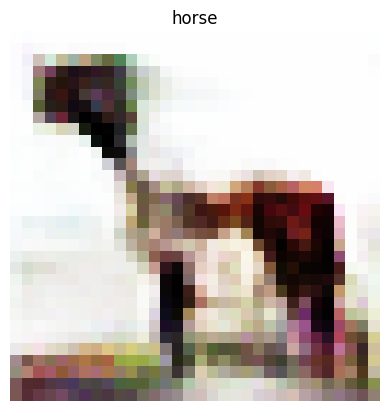

In [ ]:
# Generate sample
def generate_sample_2(generator, roberta_model, adapter, caption, NOISE_DIM=100):
    # set generator to evaluation code
    generator.eval()

    with torch.no_grad():
        # encoding caption and adapting embedding
        encoded_text = roberta_model.encode(caption).to(device)
        conditioned_embedding = adapter(encoded_text).to(device)
        print('conditioned_embedding shape:', conditioned_embedding.shape)

        # generating raondom noise vector
        noise = torch.randn(1, NOISE_DIM, 1, 1, device=device)
        # fake_image = generator(conditioned_embedding)
        fake_image = generator(noise, conditioned_embedding)

        # post-process
        img = fake_image[0].cpu().detach().numpy()
        img = (img * 127.5 + 127.5).astype(int)
        # img = img * 255
        img = np.transpose(img, (1, 2, 0))  # img shape [C, H, W] -> [H, W, C]

        # visualize
        plt.imshow(img)
        plt.axis('off')
        plt.title(caption)
        plt.show()

# generate one sample
generate_sample_2(generator_2, roberta_model, adapter, "horse", NOISE_DIM)

In [ ]:
# Vanilla GAN that only takes in noise signal used for ablation experiments
class VanillaGenerator(nn.Module):
    def __init__(self):
        super(VanillaGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(NOISE_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.main(noise)

class VanillaDiscriminator(nn.Module):
    def __init__(self):
        super(VanillaDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image):
        image = image.float()
        return self.main(image).view(-1, 1).squeeze(1)

In [ ]:
# Training code (Vanilla GAN, no label, just generates image from noise)

# hyperparameters
LEARNING_RATE = 2e-4
N_EPOCHS = 50
NOISE_DIM = 100
LABEL_REAL = 1
LABEL_FAKE = 0

def GAN_training_vanilla():
  # loading dataset
  train_dataset = CIFAR10WithCaptions(full_dataset, captions)
  train_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size = 128, shuffle = True, num_workers = 2)
  dataloader = train_dataloader
  fixed_caption = None

  # instantiating a generator netowrk
  generator = VanillaGenerator().to(device)
  generator.apply(weights_init)

  # instantiating a discriminator netowrk
  discriminator = VanillaDiscriminator().to(device)
  discriminator.apply(weights_init)

  # setting up the optimizers
  optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
  optimizer_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

  # setting criterion
  criterion = nn.BCELoss()

  for epoch in range(N_EPOCHS):
      pbar = tqdm(data_loader, desc=f"Epoch [{epoch+1}/{N_EPOCHS}]", leave=False)
      for i, data in enumerate(pbar, 0):
          # ===============================
          # updating discriminator network
          # ===============================
          # the goal is to maximize log(D(x)) + log(1 - D(G(z)))
          # training with real images
          discriminator.zero_grad()
          real_samples = data[0].to(device)
          batch_size = real_samples.size(0)
          label = torch.full((batch_size,), LABEL_REAL, device=device)
          label = label.float()

          # to visualize the progress of training
          if fixed_caption is None:
              FIXED_NOISE = torch.randn(128, NOISE_DIM, 1, 1, device=device)
              fixed_caption = "don't matter"
              fixed_real = real_samples

          output = discriminator(real_samples)
          error_discriminator_real = criterion(output, label)
          error_discriminator_real.backward(retain_graph=True)
          D_of_x = output.mean().item()

          # training with fake
          noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
          fake = generator(noise)
          label.fill_(LABEL_FAKE)
          output = discriminator(fake.detach())
          error_discriminator_fake = criterion(output, label)
          error_discriminator_fake.backward(retain_graph=True)
          error_discriminator = error_discriminator_real + error_discriminator_fake
          optimizer_discriminator.step()
          D_of_G_z1 = output.mean().item()


          # ===========================
          # updating generator network
          # ===========================
          # the goal is to maximize log(D(G(z)))
          generator.zero_grad()
          label.fill_(LABEL_REAL)  # fake labels are real for generator cost
          output = discriminator(fake)
          error_generator = criterion(output, label)
          error_generator.backward()
          optimizer_generator.step()
          D_of_G_z2 = output.mean().item()

      tqdm.write(f"[Epoch {epoch+1}/{N_EPOCHS}] D_loss={error_discriminator.item():.3f} G_loss={error_generator.item():.3f}")

  return generator, discriminator

In [ ]:
generator_vanilla, discriminator_vanilla = GAN_training_vanilla()

Epoch [1/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/50] D_loss=0.010 G_loss=5.656


Epoch [2/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/50] D_loss=0.001 G_loss=7.142


Epoch [3/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/50] D_loss=0.000 G_loss=8.184


Epoch [4/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/50] D_loss=0.000 G_loss=8.901


Epoch [5/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/50] D_loss=0.000 G_loss=10.415


Epoch [6/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/50] D_loss=100.000 G_loss=0.000


Epoch [7/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/50] D_loss=100.000 G_loss=0.000


Epoch [8/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/50] D_loss=100.000 G_loss=0.000


Epoch [9/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/50] D_loss=100.000 G_loss=0.000


Epoch [10/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/50] D_loss=100.000 G_loss=0.000


Epoch [11/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 11/50] D_loss=100.000 G_loss=0.000


Epoch [12/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 12/50] D_loss=100.000 G_loss=0.000


Epoch [13/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 13/50] D_loss=100.000 G_loss=0.000


Epoch [14/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 14/50] D_loss=100.000 G_loss=0.000


Epoch [15/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 15/50] D_loss=100.000 G_loss=0.000


Epoch [16/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 16/50] D_loss=100.000 G_loss=0.000


Epoch [17/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 17/50] D_loss=100.000 G_loss=0.000


Epoch [18/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 18/50] D_loss=100.000 G_loss=0.000


Epoch [19/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 19/50] D_loss=100.000 G_loss=0.000


Epoch [20/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 20/50] D_loss=100.000 G_loss=0.000


Epoch [21/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 21/50] D_loss=100.000 G_loss=0.000


Epoch [22/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 22/50] D_loss=100.000 G_loss=0.000


Epoch [23/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 23/50] D_loss=100.000 G_loss=0.000


Epoch [24/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 24/50] D_loss=100.000 G_loss=0.000


Epoch [25/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 25/50] D_loss=100.000 G_loss=0.000


Epoch [26/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 26/50] D_loss=100.000 G_loss=0.000


Epoch [27/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 27/50] D_loss=100.000 G_loss=0.000


Epoch [28/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 28/50] D_loss=100.000 G_loss=0.000


Epoch [29/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 29/50] D_loss=100.000 G_loss=0.000


Epoch [30/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 30/50] D_loss=100.000 G_loss=0.000


Epoch [31/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 31/50] D_loss=100.000 G_loss=0.000


Epoch [32/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 32/50] D_loss=100.000 G_loss=0.000


Epoch [33/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 33/50] D_loss=100.000 G_loss=0.000


Epoch [34/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 34/50] D_loss=100.000 G_loss=0.000


Epoch [35/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 35/50] D_loss=100.000 G_loss=0.000


Epoch [36/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 36/50] D_loss=100.000 G_loss=0.000


Epoch [37/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 37/50] D_loss=100.000 G_loss=0.000


Epoch [38/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 38/50] D_loss=100.000 G_loss=0.000


Epoch [39/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 39/50] D_loss=100.000 G_loss=0.000


Epoch [40/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 40/50] D_loss=100.000 G_loss=0.000


Epoch [41/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 41/50] D_loss=100.000 G_loss=0.000


Epoch [42/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 42/50] D_loss=100.000 G_loss=0.000


Epoch [43/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 43/50] D_loss=100.000 G_loss=0.000


Epoch [44/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 44/50] D_loss=100.000 G_loss=0.000


Epoch [45/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 45/50] D_loss=100.000 G_loss=0.000


Epoch [46/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 46/50] D_loss=100.000 G_loss=0.000


Epoch [47/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 47/50] D_loss=100.000 G_loss=0.000


Epoch [48/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 48/50] D_loss=100.000 G_loss=0.000


Epoch [49/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 49/50] D_loss=100.000 G_loss=0.000


Epoch [50/50]:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 50/50] D_loss=100.000 G_loss=0.000


torch.Size([1, 3, 32, 32])


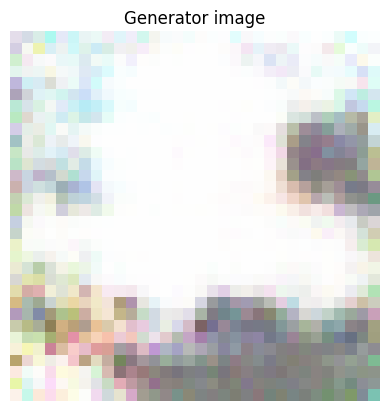

In [ ]:
# Generate sample
def generate_sample_vanilla(generator, NOISE_DIM=100):
    # set generator to evaluation code
    generator.eval()

    with torch.no_grad():
        # encode caption and adapt embedding
        # generate raondom noise vector
        # noise = torch.randn(1, NOISE_DIM, device=device)

        # concatenate and generate image
        # generator_input = torch.cat([conditioned_embedding, noise], dim=1)
        # fake_image = generator(generator_input)
        label = torch.full((1,), LABEL_REAL, device=device)
        label = label.float()
        noise = torch.randn(1, NOISE_DIM, 1, 1, device=device)
        fake_image = generator(noise)
        print(fake_image.shape)

        # post-process
        img = fake_image[0].cpu().detach().numpy()
        img = (img * 127.5 + 127.5).astype(int)
        # img = img * 255
        img = np.transpose(img, (1, 2, 0))  # img shape [C, H, W] -> [H, W, C]

        # visualize
        plt.imshow(img)
        plt.axis('off')
        plt.title("Generator image")
        plt.show()

# generate one sample
generate_sample_vanilla(generator_vanilla, NOISE_DIM)

In [ ]:
# Metrics
# 1. FID - with pretrained InceptionV3
# 2. CLIP score
# 3. Pairwise diversity metric -> L2 or SSIM distance
# 4. Train a simple CNN (or pretrained?) to determine generated image from real image (i.e. lower accuracy -> better GAN performance)

**FID - using pretrained InceptionV3**

In [ ]:
# Load the InceptionV3 model
def get_inception_v3():
  model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
  # Replace the final classification layer of InceptionV3 with Identity to extract the 2048-dim features
  model.fc = nn.Identity()
  model.to(device)
  model.eval()

  return model

In [ ]:
# Resize the images into 299x299 so that the features can be extracted since this is the shape InceptionV3 expects
transform_for_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Now we use InceptionV3 to extract the features from the images
@torch.no_grad()
def get_activations(images, model, device):
  batch = torch.stack([transform_for_inception(image) for image in images]).to(device) # after batching, the shape is [B, 3, 299, 299]
  extracted_features = model(batch) # The output size should be [B, 2048]

  return extracted_features.cpu().numpy()

For two distribution $X \sim N(\mu_1, \Sigma_1)$ and $Y \sim N(\mu_2, \Sigma_2)$ with $\mu_i \in \mathbb{R}^d$ and $\Sigma_i \in \mathbb{R}^{d \times d}$ as the mean vector and covariance matrix, the FID between these two distributions is defined as:
$$ D_F = \left \| \mu_1 - \mu_2 \right \|^2 + \text{tr}(\Sigma_1 + \Sigma_2 - 2(\Sigma_1 \Sigma_2)^{1/2})$$
where $\text{tr}(\cdot)$ is the trace.

In [ ]:
# Now we calculate the FID with the extracted features of the images
def calculate_fid(mu1, sigma1, mu2, sigma2):
  diff = mu1 - mu2
  norm_sq = diff.dot(diff)
  covmean = sqrtm(sigma1 @ sigma2)
  if np.iscomplexobj(covmean):
    covmean = covmean.real

  return norm_sq + np.trace(sigma1 + sigma2 - 2 * covmean)

def get_fid_score(real_img_features, fake_img_features):
  # features have shape [B, 2048] -> outputs from get_activations
  mu1, sigma1 = real_img_features.mean(axis=0), np.cov(real_img_features, rowvar=False) # set rowvar=False since each row represents one image
  mu2, sigma2 = fake_img_features.mean(axis=0), np.cov(fake_img_features, rowvar=False)

  return calculate_fid(mu1, sigma1, mu2, sigma2)


In [ ]:
# Calculate FID with the images
# Get InceptionV3 model for FID calculation
inception_model = get_inception_v3()

# Create a DataLoader for the entire dataset to generate fake images
full_dataset_dataloader_generation = torch.utils.data.DataLoader(cifar10_with_captions, batch_size=128, shuffle=False, num_workers=2)

all_real_feats = []
all_fake_feats = []

generator.eval()
adapter.eval()

print("Processing dataset in batches to generate fake images and calculate FID...")
# Iterate through the dataset to generate fake images and collect features
for i, (real_images, real_labels, real_captions) in enumerate(tqdm(full_dataset_dataloader_generation)):
    # Generate fake images using the trained generator and adapter
    with torch.no_grad():
        # Encode the real captions using RoBERTa and the adapter
        encoded_text = roberta_model.encode(real_captions).to(device)
        conditioned_embedding = adapter(encoded_text).to(device)

        # Generate noise
        noise = torch.randn(real_images.size(0), NOISE_DIM, 1, 1, device=device)

        # Generate fake images
        fake_images = generator(noise, conditioned_embedding)

    # Convert fake images tensor to a list of PIL Images for the transform
    fake_images_pil = [transforms.ToPILImage()(img.cpu() * 0.5 + 0.5) for img in fake_images] # Denormalize and convert to PIL
    real_images_pil = [transforms.ToPILImage()((img.cpu() * 0.5 + 0.5)) for img in real_images] # Denormalize before converting to PIL


    # Get activations for real and fake images in smaller batches for feature extraction
    real_feats_batch = get_activations(real_images_pil, inception_model, device)
    fake_feats_batch = get_activations(fake_images_pil, inception_model, device)

    all_real_feats.append(real_feats_batch)
    all_fake_feats.append(fake_feats_batch)

# Concatenate features from all batches
all_real_feats = np.vstack(all_real_feats)
all_fake_feats = np.vstack(all_fake_feats)

# Calculate FID
print("\nCalculating FID...")
fid_value = get_fid_score(all_real_feats, all_fake_feats)
print(f"FID: {fid_value:.4f}")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 231MB/s] 


Processing dataset in batches to generate fake images and calculate FID...


  0%|          | 0/391 [00:00<?, ?it/s]


Calculating FID...
FID: 65.0927


**CLIP Score**

In [ ]:
# For clip score, we will use open clip with pretrained model and weights
clip_model_eval_name = "ViT-B-16"
clip_model_eval_weights = "openai"
clip_model_eval, _, clip_preprocess_eval = open_clip.create_model_and_transforms(clip_model_eval_name, pretrained=clip_model_eval_weights)
clip_eval_tokenizer = open_clip.get_tokenizer(clip_model_eval_name)
clip_model_eval.to(device)
clip_model_eval.eval()

open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [ ]:
# Function for calculating CLIP score
# Takes in the text prompt and the images, and computes the CLIP score bewteen them
@torch.no_grad()
def compute_clip_score(text_prompts, images, model, preprocess, tokenizer):
  # text tokens tensor shape - [B, seq_len]
  # images tensor shape = [B, 3, H, W]
  text_tokens = tokenizer(text_prompts).to(device)
  images_tensor = torch.stack([preprocess(image) for image in images]).to(device)

  # encode with the clip model
  texts_features = model.encode_text(text_tokens)
  images_features = model.encode_image(images_tensor)

  # normalize the features so that the L2 norm is 1
  images_features /= images_features.norm(dim=-1, keepdim=True)
  texts_features /= texts_features.norm(dim=-1, keepdim=True)

  # calculate cosine similarity for each pair of text prompt with its generated image
  similarities = (images_features * texts_features).sum(dim=-1)

  return similarities.cpu().numpy()

In [ ]:
# Create a DataLoader for the entire dataset
full_dataset_dataloader_clip = torch.utils.data.DataLoader(cifar10_with_captions, batch_size=128, shuffle=False, num_workers=2)

all_clip_scores = []
real_clip_scores = []

generator.eval()
adapter.eval()
clip_model_eval.eval() # Ensure CLIP model is in evaluation mode

print("Processing dataset in batches to calculate CLIP scores...")
for i, (real_images, real_labels, real_captions) in enumerate(tqdm(full_dataset_dataloader_clip)):
    # Generate fake images using the trained generator and adapter
    with torch.no_grad():
        # Encode the real captions using RoBERTa and the adapter
        labels = [full_dataset.classes[i] for i in real_labels]
        encoded_text = roberta_model.encode(labels).to(device)
        conditioned_embedding = adapter(encoded_text).to(device)

        # Generate noise
        noise = torch.randn(real_images.size(0), NOISE_DIM, 1, 1, device=device)

        # Generate fake images
        fake_images = generator(noise, conditioned_embedding)

    # Convert fake images tensor to a list of PIL Images for the transform
    fake_images_pil = [transforms.ToPILImage()(img.cpu()) for img in fake_images]
    real_images_pil = [transforms.ToPILImage()(img.cpu()) for img in real_images]

    # Calculate CLIP scores for the current batch
    batch_clip_scores = compute_clip_score(real_captions, fake_images_pil, clip_model_eval, clip_preprocess_eval, clip_eval_tokenizer)
    real_batch_clip_scores = compute_clip_score(real_captions, real_images_pil, clip_model_eval, clip_preprocess_eval, clip_eval_tokenizer)
    all_clip_scores.extend(batch_clip_scores)
    real_clip_scores.extend(real_batch_clip_scores)


# Calculate the average CLIP score
average_clip_score = np.mean(all_clip_scores)
average_clip_score_real = np.mean(real_batch_clip_scores)

print(f"\nAverage CLIP score for the entire dataset: {average_clip_score:.4f}")
print(f"\nAverage CLIP score for the real dataset: {average_clip_score_real:.4f}")

Processing dataset in batches to calculate CLIP scores...


  0%|          | 0/391 [00:00<?, ?it/s]


Average CLIP score for the entire dataset: 0.2272

Average CLIP score for the real dataset: 0.2410


**L2 Distance**

We can vectorize and calculate the L2 distance between each images using this formula:
$$\left \| x - y \right \|^2 = \left \| x \right \|^2 + \left \| y \right \|^2 - 2(x \cdot y)$$

In [ ]:
# Pairwise diversity metric - Average L2 between a batch of generated images
# Want to see how similar are the images generated from the same text prompt, detecting if model collasped
def compute_L2_distance(images):
  # images expected to be a tensor with shape [B, C, H, W]
  images = images.float()
  img_min, img_max = images.min(), images.max()
  if img_max > img_min:  # avoid division by zero
    images = (images - img_min) / (img_max - img_min)

  images_flat = images.view(images.size(0), -1) # shape [B, C*H*W]
  images_dot_product = images_flat @ images_flat.T # [B, B]

  norms_sq = torch.sum(images_flat ** 2, dim=1, keepdim=True) # shape [B, 1]
  dist_sq = norms_sq + norms_sq.T - 2 * images_dot_product

  dist_sq = torch.clamp(dist_sq, min=0.0)

  l2_distances = torch.sqrt(dist_sq)

  # get upper triangular for pairwise distances, since l2_distances[i, j] = l2_distances[j, i]
  n = images_flat.size(0)
  triu_indices = torch.triu_indices(n, n, offset=1, device=images.device)
  pairwise_dists = l2_distances[triu_indices[0], triu_indices[1]]

  return pairwise_dists.mean().item()

In [ ]:
full_dataset_caption_dataloader_clip = torch.utils.data.DataLoader(captions, batch_size=128, shuffle=False, num_workers=2)
all_generated_images = []
generator.eval()
adapter.eval()
total_L2 = 0
num_batches = 0
print("Processing dataset in batches to calculate L2 distances...")
for i, batch_labels in enumerate(tqdm(full_dataset_caption_dataloader_clip)):
    # Generate fake images using the trained generator and adapter
    with torch.no_grad():
        # Encode the captions using RoBERTa and the adapter
        encoded_text = roberta_model.encode(batch_labels).to(device)
        conditioned_embedding = adapter(encoded_text).to(device)

        # Generate noise
        noise = torch.randn(conditioned_embedding.size(0), NOISE_DIM, 1, 1, device=device)

        # Generate fake images
        fake_images = generator(noise, conditioned_embedding)
        batch_L2 = compute_L2_distance(fake_images)  # This should be per batch
        total_L2 += batch_L2
        num_batches += 1

print(f"\nAverage L2 distance for the entire dataset: {total_L2 / num_batches:.4f}")

Processing dataset in batches to calculate L2 distances...


  0%|          | 0/391 [00:00<?, ?it/s]


Average L2 distance for the entire dataset: 18.2541
